In [ ]:
import importlib
import os
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import dill
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from scipy.spatial import KDTree
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats._continuous_distns import genpareto
import pandas as pd

import grapher

# Custom    
import mstmeclass as mc
from mstmeclass import MSTME, SIMSET, STM, Area

os.environ["OPENBLAS_MAIN_FREE"] = "1"
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use("./src/plot_style.txt")

: 

# Load data

In [2]:
preset = 2
match preset:
    case 0:
        output="output"
        region = "guadeloupe"
        N_subsample = 100
        rf = "h-east"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.9
    case 1:
        output="output"
        region = "guadeloupe"
        N_subsample = 100
        rf = "h-west"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.65
    case 2:
        output="output-new"
        region = "guadeloupe-wide"
        N_subsample = 100
        rf = "h-east"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.9
    case 3:
        output="output-new"
        region = "guadeloupe-wide"
        N_subsample = 100
        rf = "h-west"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.70
    case 4:
        output="output-new"
        region = "guadeloupe-wide"
        N_subsample = 100
        rf = "none"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.70

In [3]:
path_mstme = Path(
    f"./{output}/{region}/{rf}/GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%_{N_subsample}subsamples/mstme_condition.dill"
)
with open(path_mstme, "rb") as f:
    mstme_condition: MSTME = dill.load(f)
    tree = KDTree(mstme_condition.latlon)
    grid_res = 10
    lat_list = np.linspace(15.80, 16.60, grid_res)
    lon_list = np.linspace(-62.00,-60.80, grid_res)
    dist_list, pos_list = tree.query(
        [[[lat, lon] for lat in lat_list] for lon in lon_list]
    )
    # lat_list = np.linspace(mstme_condition.area.min_lat, mstme_condition.area.max_lat, grid_res)
    # lon_list = np.linspace(mstme_condition.area.min_lon, mstme_condition.area.max_lon, grid_res)
    # dist_list, pos_list = tree.query(
    #     [[[lat, lon] for lat in lat_list] for lon in lon_list]
    # )
    pos_list = pos_list.flatten()
    pos_list = np.unique(pos_list)
    # if not hasattr(mstme_condition, "pval"):
    #     mstme_condition.calc_kendall_tau()
    # ratio_kt_fail = (
    #     np.count_nonzero(mstme_condition.pval[:, :, pos_list] < 0.05, axis=2) / pos_list.size
    # )

In [4]:
rng = np.random.default_rng()

In [6]:
N_year_pool = 200
N_subsample = 1000
path_mstme_ss_dill = path_mstme.parent.joinpath(
    f"mstme_ss_{N_subsample}_pool_{N_year_pool}.dill"
)
if path_mstme_ss_dill.exists():
    with open(path_mstme_ss_dill, "rb") as f:
        tm_MSTME_ss, stm_MSTME_ss = dill.load(f)
    if tm_MSTME_ss.shape[0] != N_subsample:
        warnings.warn(
            f"Sample count of {tm_MSTME_ss.shape[0]} for mstme_ss_dill does not match the input:{N_subsample} (GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%)"
        )
else:   
    try:
        tm_MSTME_ss, stm_MSTME_ss = mc.subsample_MSTME(
            mstme_condition,
            N_subsample,
            N_year_pool,
            pos_list=pos_list,
        )
        with path_mstme_ss_dill.open("wb") as f:
            dill.dump((tm_MSTME_ss, stm_MSTME_ss), f)
    except mc.SubsampleException as e:
        print(e)

In [5]:
dir_out = Path(f"./{output}/{region}/{rf}/summary")
if not dir_out.exists():
    dir_out.mkdir(parents=True, exist_ok=True)

# Marginal results

## STM

### Subsample GPD

In [7]:
# make event masks for subsampling shared by mstme and pwe
num_ss = 1000
_num_events_ss = round(N_year_pool * mstme_condition.occur_freq)
_mask_ss = mc._get_ss_pool(mstme_condition, num_ss, _num_events_ss)
genpar_params_ss = []
for ssi in range(num_ss):
    print(ssi)
    # _mask = np.logical_and(_mask_ss[ssi],mstme_condition.is_e_mar[vi])
    _mask = _mask_ss[ssi]
    _, genpar_params = mc._genpar_estimation(mstme_condition.get_root().stm[:,_mask],mstme_condition.thr_mar)
    genpar_params_ss.append(genpar_params)
genpar_params_ss = np.array(genpar_params_ss)
genpar_params_u95 = np.percentile(np.mean(genpar_params_ss,axis=2),97.5,axis=0)
genpar_params_l95 = np.percentile(np.mean(genpar_params_ss,axis=2),02.5,axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

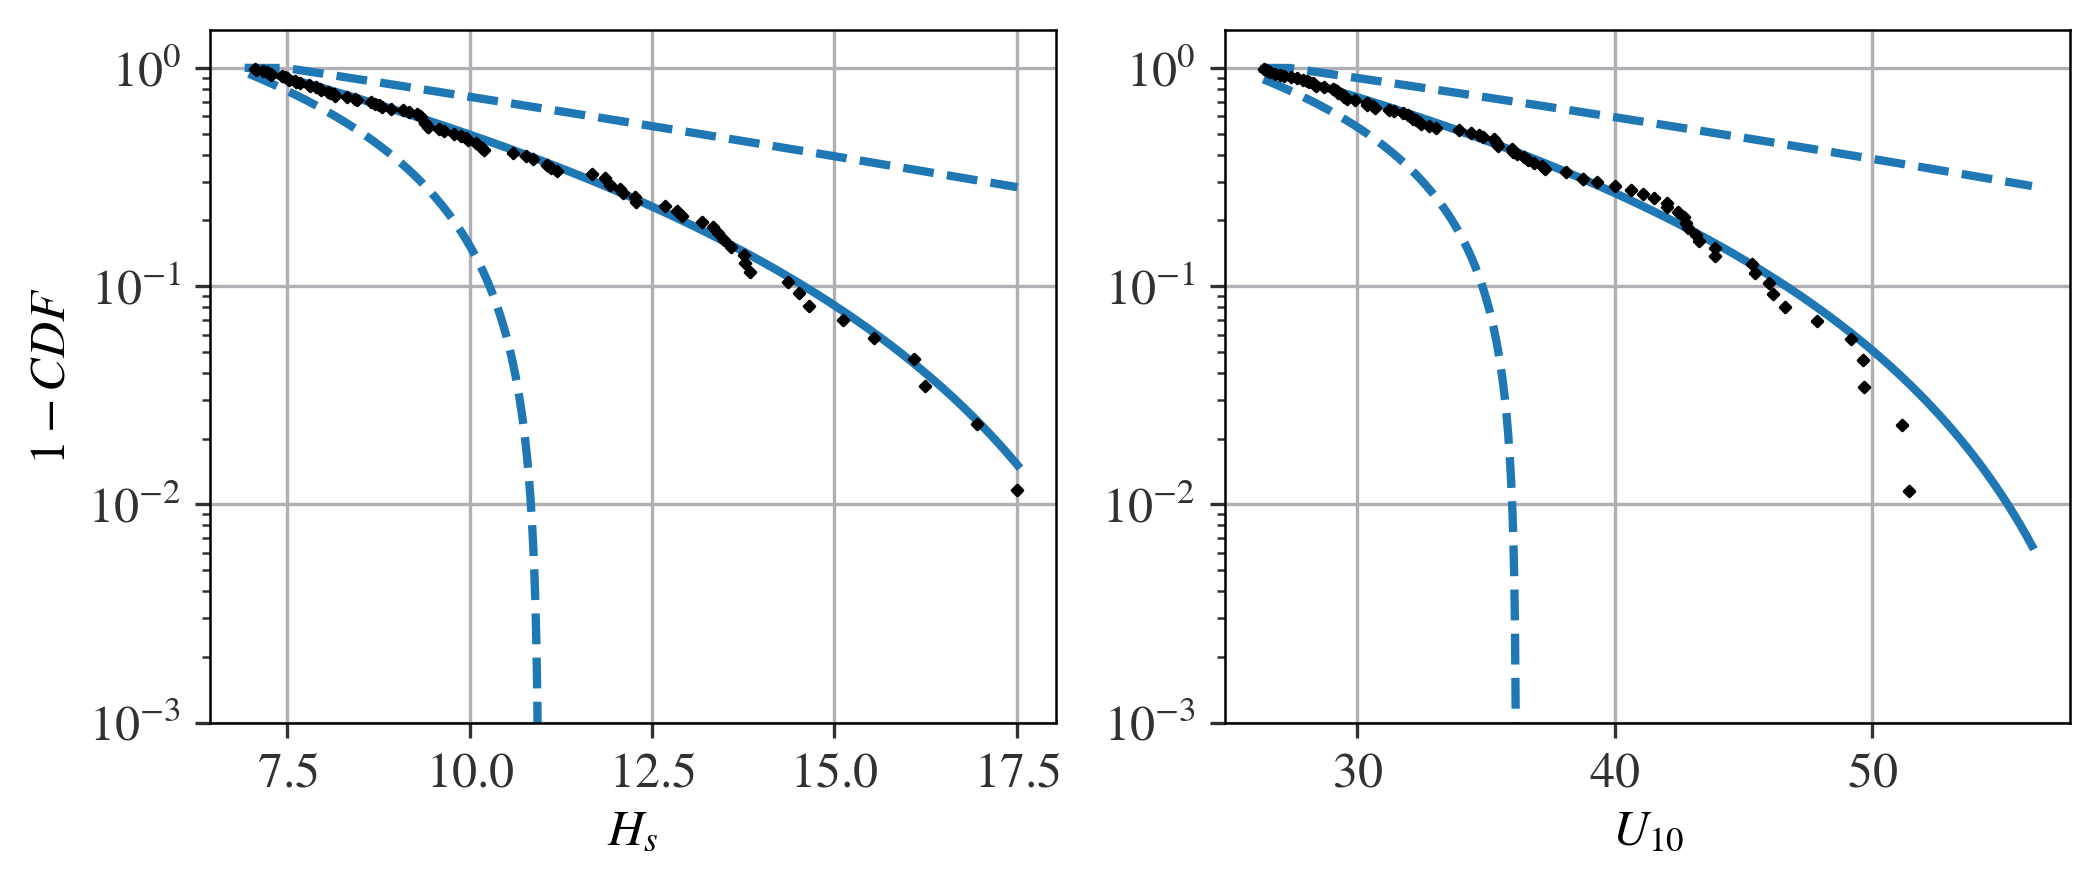

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 3), facecolor="white")
for S in STM:
    vi = S.idx()
    stm = mstme_condition.stm[vi, mstme_condition.is_e_mar[vi]]
    x = np.linspace(mstme_condition.thr_mar[vi], stm.max(), 1000)
    ax[vi].plot(
        x,
        1
        - genpareto(
            c=genpar_params_u95[vi][0],
            loc=genpar_params_u95[vi][1],
            scale=genpar_params_u95[vi][2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c=pos_color[0],
        label="Subsample 95th percentile",
    )
    ax[vi].plot(
        x,
        1
        - genpareto(
            c=genpar_params_l95[vi][0],
            loc=genpar_params_l95[vi][1],
            scale=genpar_params_l95[vi][2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c=pos_color[0],
    )
    ax[vi].plot(x, 1 - mstme_condition.gp[vi].cdf(x), lw=2, c=pos_color[0], label="All events")
    ecdf = ECDF(stm)
    ax[vi].scatter(
        stm, 1 - ecdf(stm), c="k", marker="D", s=3, zorder=10, label="Sample"
    )
    ax[vi].grid(which="major")
    # ax[vi].grid(which='minor')
    ax[vi].set_xlabel(f"{S.name()}")
    ax[vi].set_yscale("log")
    ax[vi].set_ylim(bottom=1e-3, top=1.5)
ax[0].set_ylabel("$1-CDF$")
# ax[0].legend()

plt.savefig(dir_out/f"GPD_subsample.png",bbox_inches='tight')
plt.savefig(dir_out/f"GPD_subsample.pdf",bbox_inches='tight')

### Bootstrap GPD

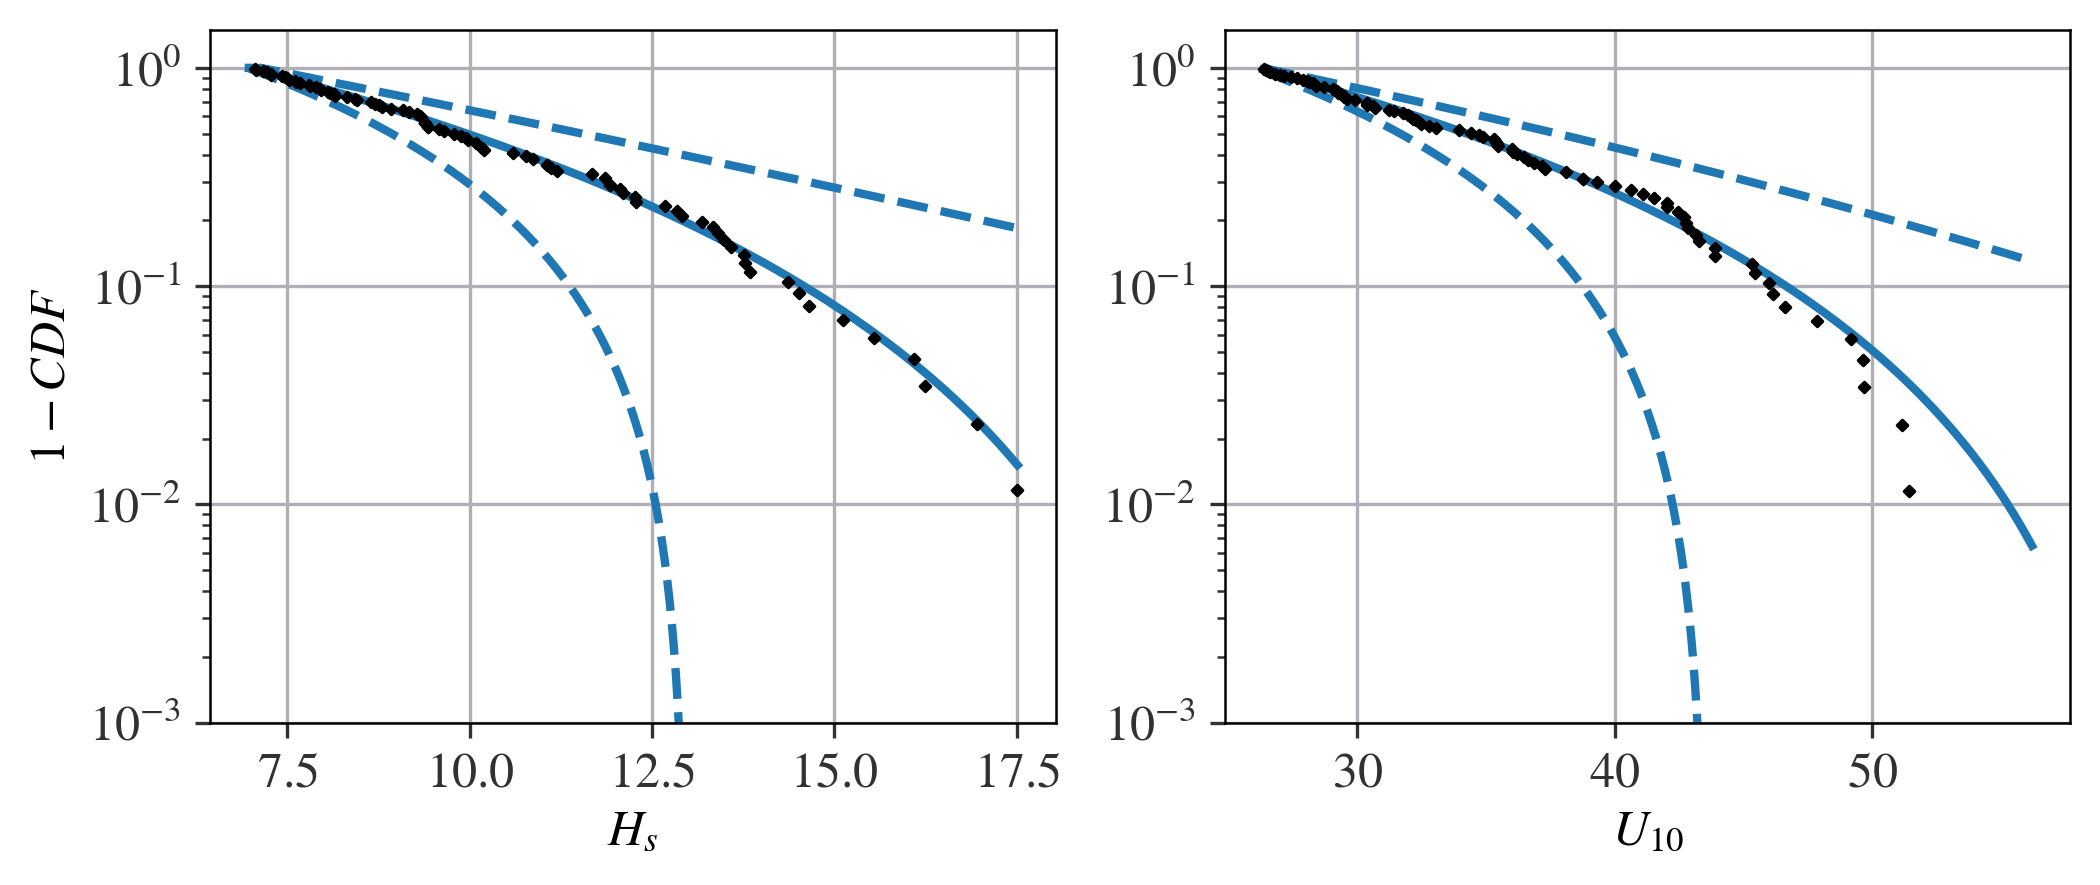

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 3), facecolor="white")
for S in STM:
    vi = S.idx()
    stm = mstme_condition.stm[vi, mstme_condition.is_e_mar[vi]]
    genpar_params = mstme_condition.gp_params[vi]
    gpp_u95 = np.percentile(genpar_params,97.5,axis=0)
    gpp_l95 = np.percentile(genpar_params,02.5,axis=0)
    gpp_med = np.percentile(genpar_params,50.0,axis=0)
    x = np.linspace(mstme_condition.thr_mar[vi], stm.max(), 1000)

    ax[vi].plot(
        x,
        1
        - genpareto(
            c=gpp_u95[0],
            loc=gpp_u95[1],
            scale=gpp_u95[2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c=pos_color[0],
        label="95th percentile",
    )
    ax[vi].plot(
        x,
        1
        - genpareto(
            c=gpp_l95[0],
            loc=gpp_l95[1],
            scale=gpp_l95[2],
        ).cdf(x),
        lw=2,
        linestyle="--",
        c=pos_color[0],
    )
    ax[vi].plot(x, 1 - mstme_condition.gp[vi].cdf(x), lw=2, c=pos_color[0], label="Mean")
    ecdf = ECDF(stm)
    ax[vi].scatter(
        stm, 1 - ecdf(stm), c="k", marker="D", s=3, zorder=10, label="Sample"
    )
    ax[vi].grid(which="major")
    # ax[vi].grid(which='minor')
    ax[vi].set_xlabel(f"{S.name()}")
    ax[vi].set_yscale("log")
    ax[vi].set_ylim(bottom=1e-3, top=1.5)
ax[0].set_ylabel("$1-CDF$")
# ax[0].legend()

plt.savefig(dir_out/f"GPD_bootstrap.png",bbox_inches='tight')
plt.savefig(dir_out/f"GPD_bootstrap.pdf",bbox_inches='tight')

# PWE

## Marginal temporal maxima

In [7]:
exceedance_prob_com_PWE = 1 - 0.7

In [8]:

return_period = 100

# Sample count over threshold
num_events_sample = tm_MSTME_ss.shape[2]
exceedance_prob_com = 1 - mstme_condition.thr_pct_com
exceedance_prob = 1 / (return_period * mstme_condition.occur_freq * exceedance_prob_com)
count_sample = round(
    num_events_sample
    / (return_period * mstme_condition.occur_freq * exceedance_prob_com)
)
num_events_original = mstme_condition.num_events
count_original = round(
    num_events_original / (return_period * mstme_condition.occur_freq)
)
exceedance_prob_original = 1 / (return_period * mstme_condition.occur_freq)


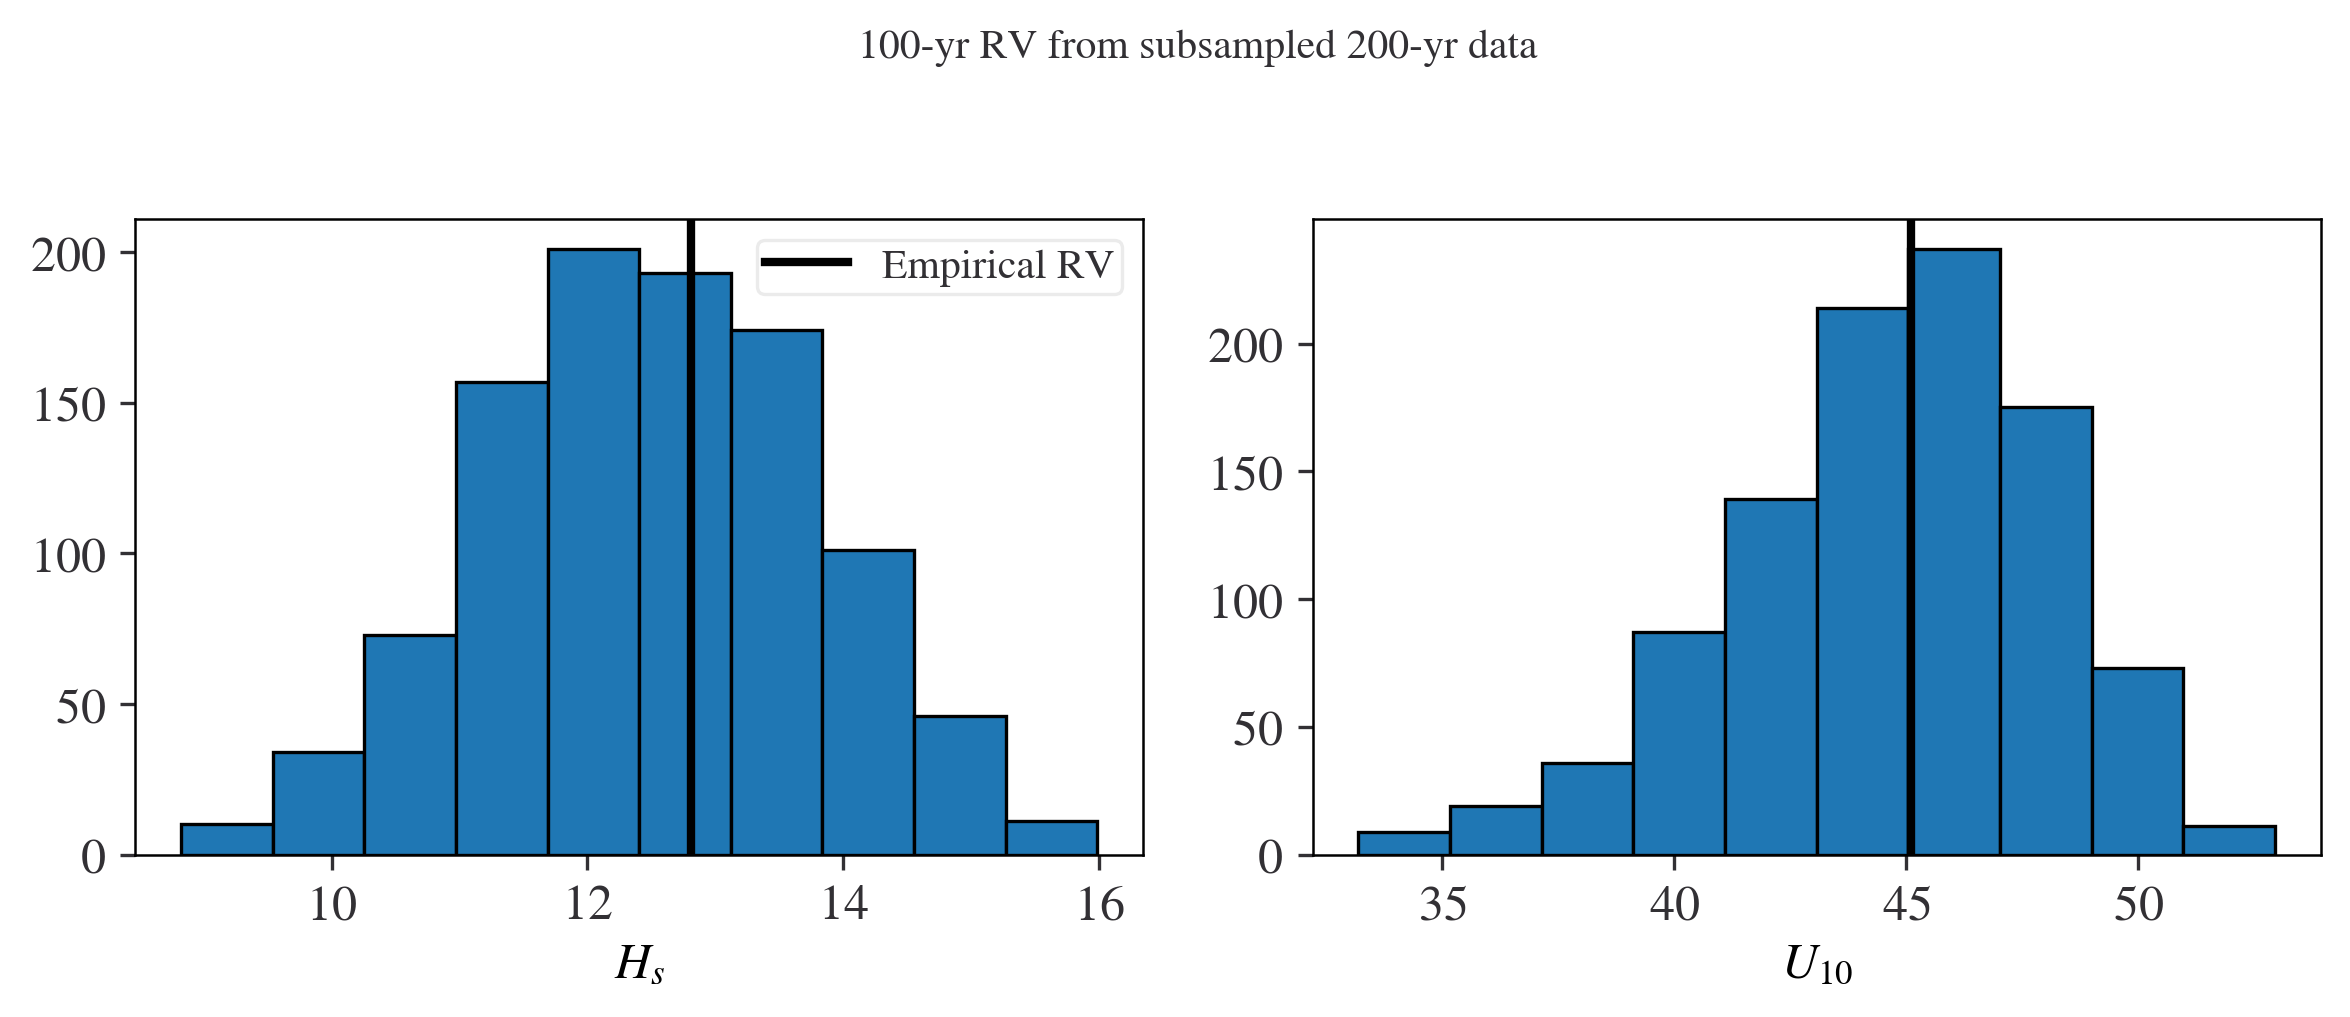

In [9]:
i = 0
ni = pos_list[i]
fig,ax= plt.subplots(1,2,figsize=(4*2,3))
fig.suptitle(f"{return_period}-yr RV from subsampled {N_year_pool}-yr data",size=10,y=1.05)
fig.tight_layout()
for S in STM:
  vi = S.idx()
  rv=[]
  for ssi in range(N_subsample):
    # calculate 100-yr RV
    tm = tm_MSTME_ss[ssi,vi,:,i]
    rv.append(np.percentile(tm,(1-exceedance_prob)*100))
  ax[vi].hist(rv)
  ax[vi].axvline(np.percentile(mstme_condition.tm[vi,:,ni],(1-exceedance_prob_original)*100),c='k')
  ax[vi].set_xlabel(S.name())
ax[0].legend([Line2D([0],[0],lw=2,color='k')],['Empirical RV'])
plt.savefig(dir_out/f"example_empirical_vs_mstme.png", bbox_inches="tight")
plt.savefig(dir_out/f"example_empirical_vs_mstme.pdf", bbox_inches="tight")

The empirical RV for $H_s$ is between 32.6% and 83.7% of the subsampled RV distribution
The empirical RV for $U_{10}$ is between 8.1% and 71.9% of the subsampled RV distribution


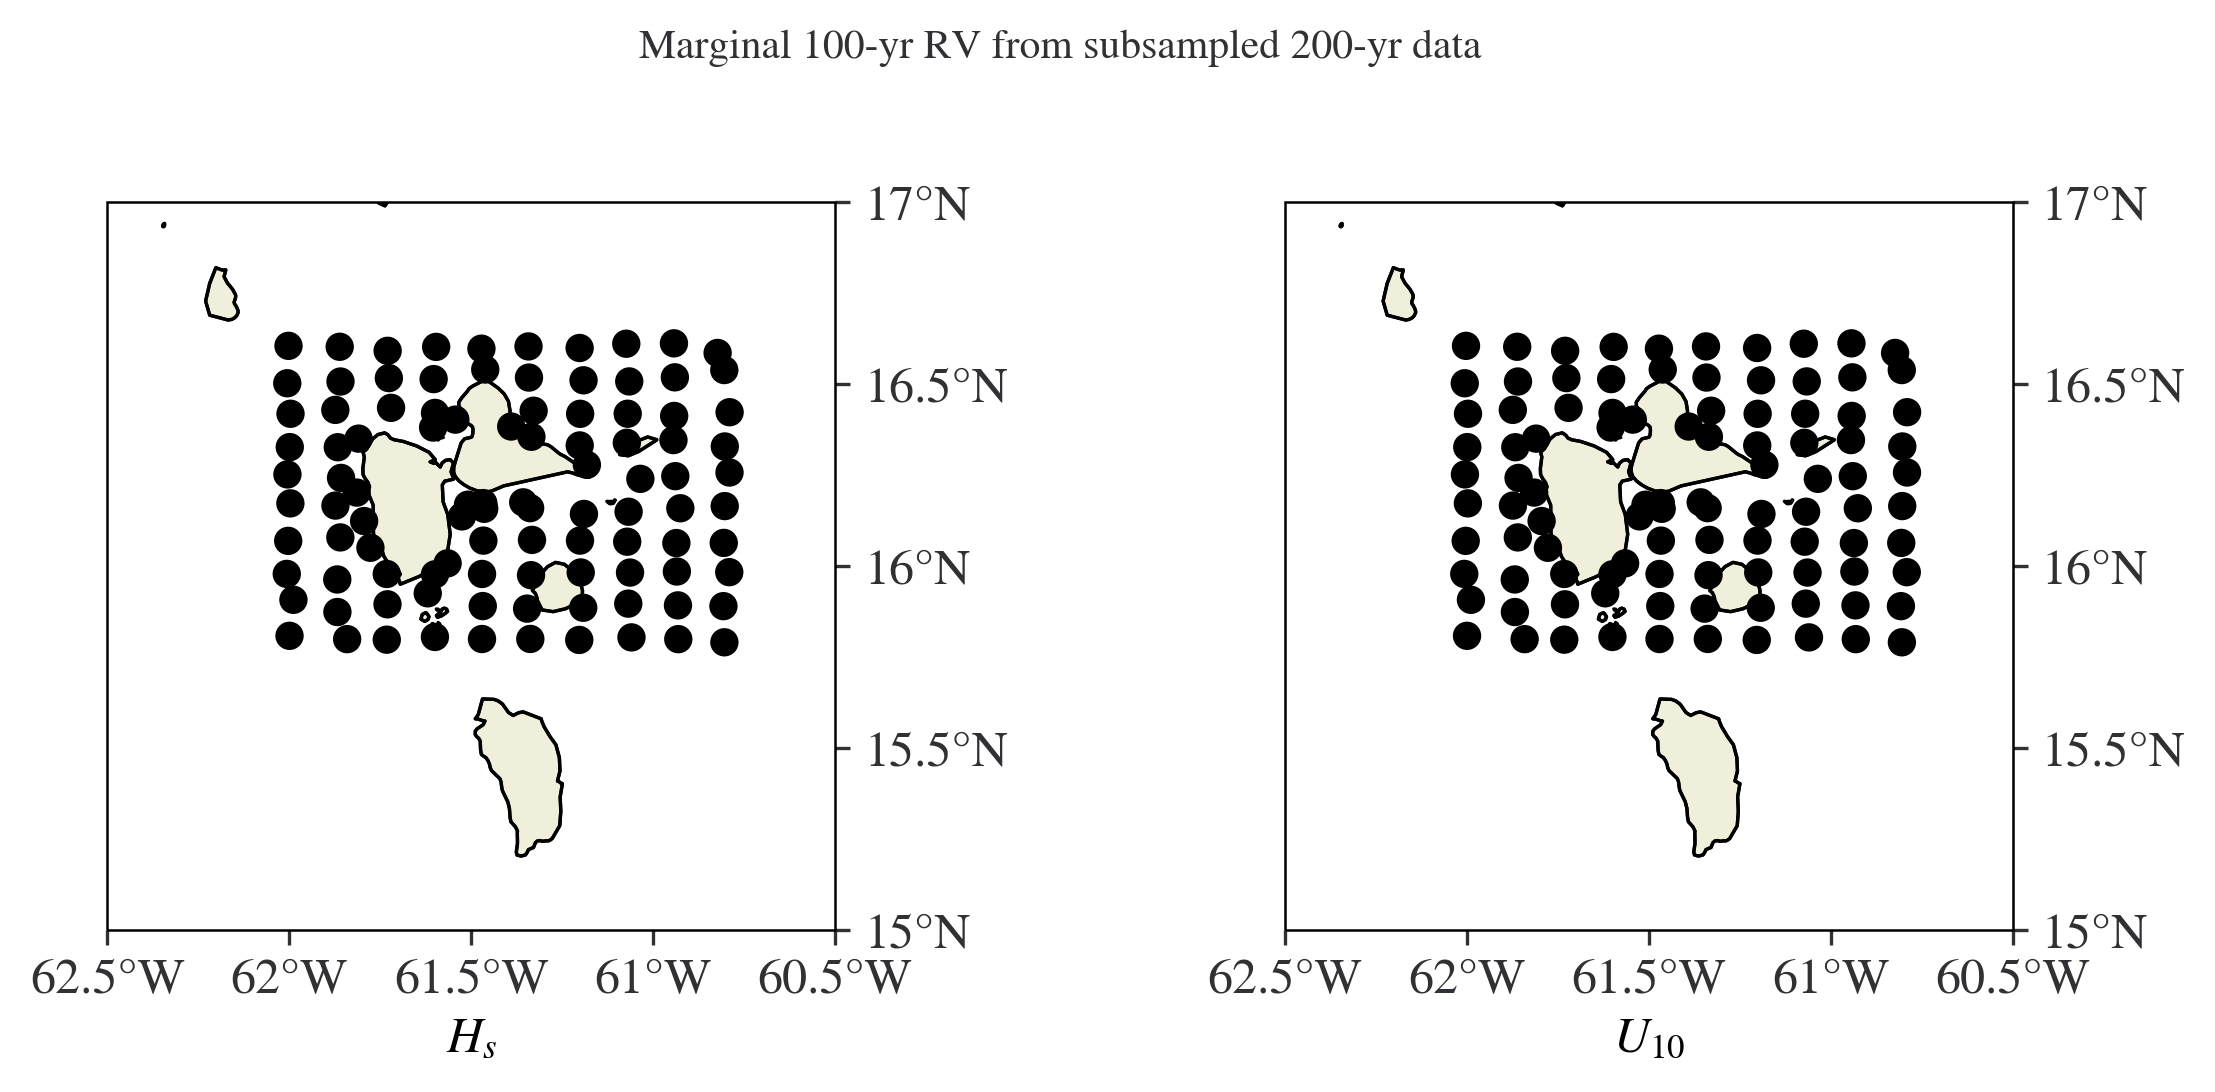

In [10]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
alpha=0.05
fig.suptitle(
    f"Marginal {return_period}-yr RV from subsampled {N_year_pool}-yr data", size=10, y=1.05
)
fig.tight_layout()
for S in STM:
    vi = S.idx()
    ax[vi] = grapher.custom_map(ax[vi], mstme_condition.area)
    pctile = []
    # for ni in range(mstme_condition.num_nodes):
    for i,ni in enumerate(pos_list):
        rv = []
        for ssi in range(N_subsample):
            # calculate 100-yr RV
            tm = tm_MSTME_ss[ssi, vi, :, i]
            rv.append(np.percentile(tm, (1 - exceedance_prob) * 100))
        rv_original = np.percentile(
            mstme_condition.tm[vi, :, ni], (1 - exceedance_prob_original) * 100
        )
        pctile.append(ECDF(rv)(rv_original))
    ax[vi].scatter(
        # mstme_condition.latlon[:, 1],
        # mstme_condition.latlon[:, 0],
        mstme_condition.latlon[pos_list, 1],
        mstme_condition.latlon[pos_list, 0],
        c=['k' if 0.5-abs(p-0.5)>alpha/2 else 'red' for p in pctile],
        vmin=0,
        vmax=1,
        cmap="seismic",
    )
    print(f"The empirical RV for {S.name()} is between {min(pctile)*100:.1f}% and {max(pctile)*100:.1f}% of the subsampled RV distribution")
    ax[vi].set_xlabel(S.name())

## Joint temporal maxima

In [11]:
tree_pwe = KDTree(mstme_condition.latlon[pos_list, :])
_, idx_list_pwe = tree_pwe.query(
    [
        [16.5,-61.8],
        [16.0,-61.9],
        [16.05,-61.4],
        [16.0,-61.0],
        [16.5,-61.1],
    ]
)
idx_list_pwe = idx_list_pwe.flatten()
idx_list_pwe = np.unique(idx_list_pwe)
pos_list_pwe = pos_list[idx_list_pwe]


In [12]:
####OVERRIDE
# from the guadeloupe(not wide) 5 locations
latlon_list_pwe = np.array(
    [
        [15.962273, -61.86822],
        [16.506672, -61.0656],
        [15.9812355, -61.063473],
        [16.506403, -61.859367],
        [16.069033, -61.466587],
    ]
)
tree_pwe_original = KDTree(mstme_condition.latlon)
_, pos_list_pwe = tree_pwe_original.query(latlon_list_pwe)
_,idx_list_pwe=tree_pwe.query(latlon_list_pwe)

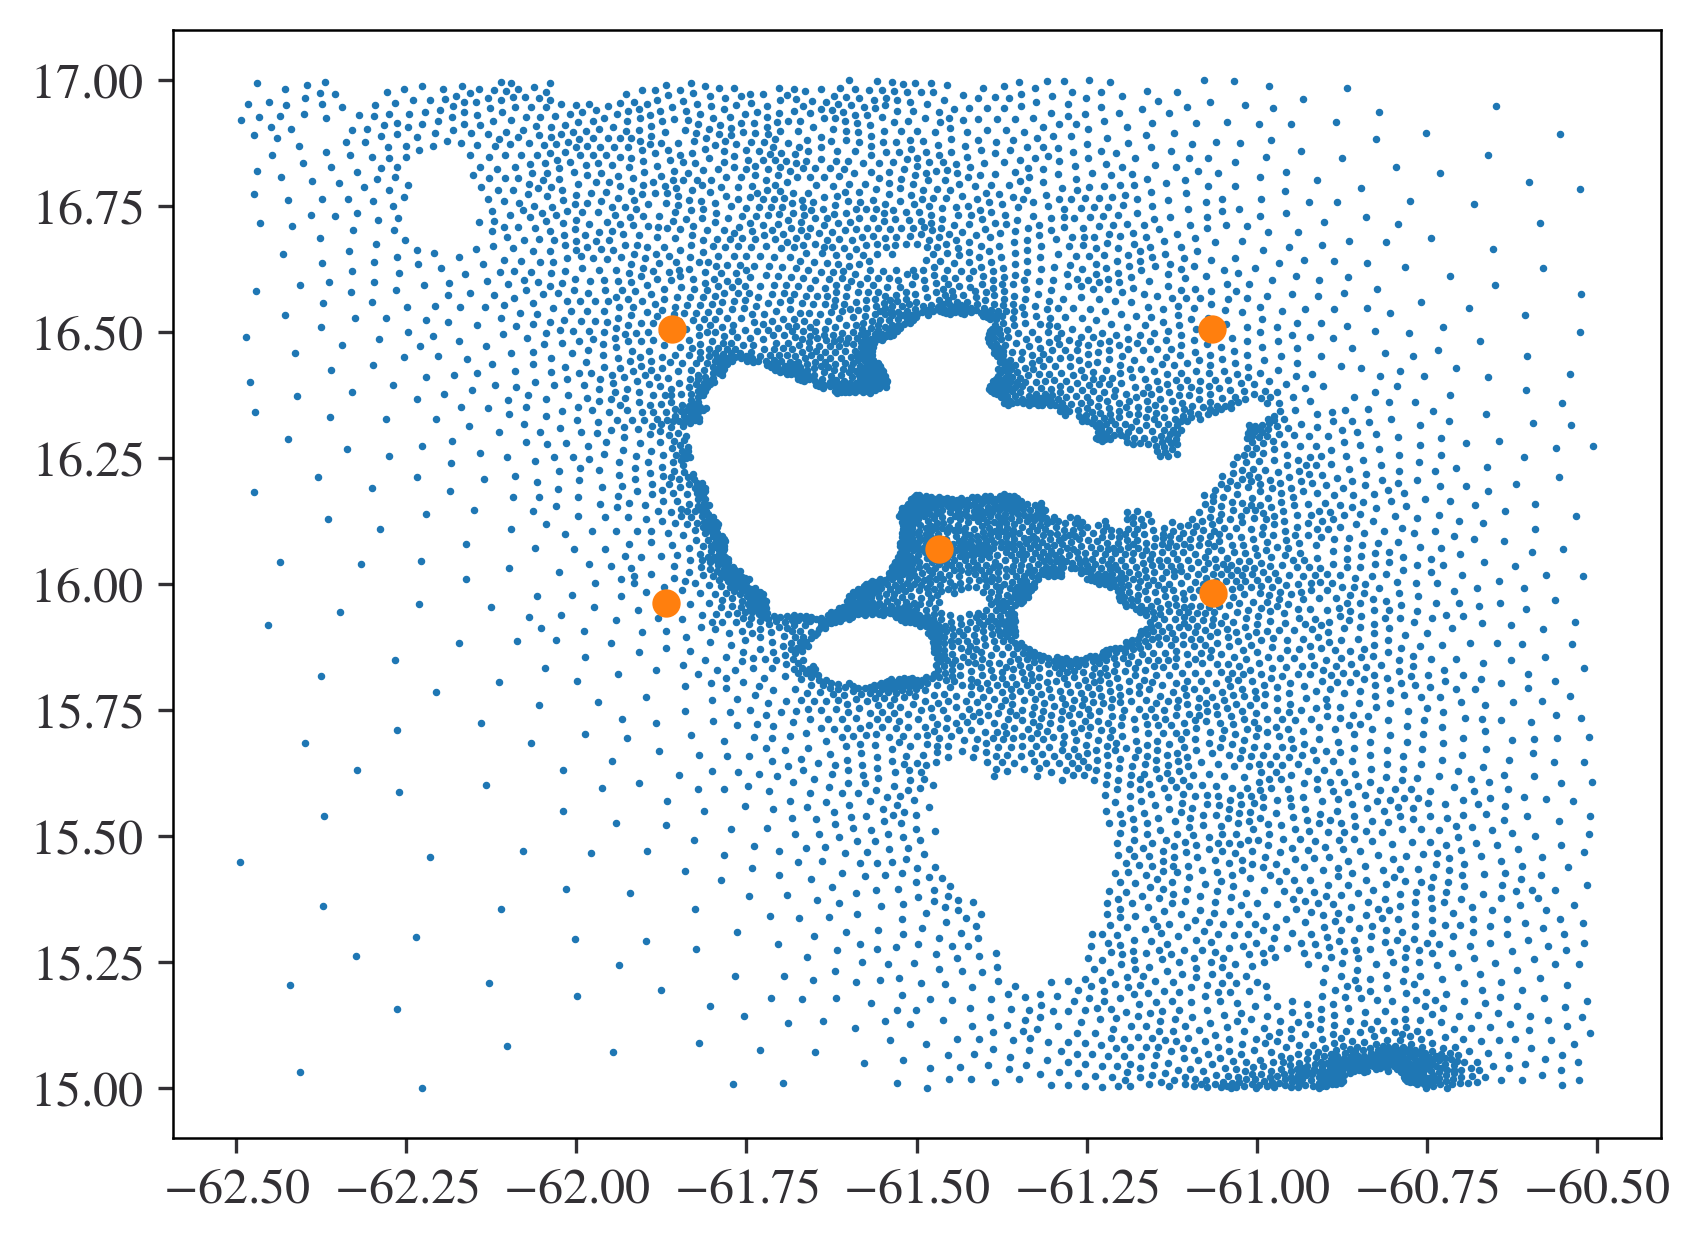

In [13]:
plt.scatter(mstme_condition.latlon[:,1],mstme_condition.latlon[:,0],s=1)
plt.scatter(mstme_condition.latlon[pos_list_pwe,1],mstme_condition.latlon[pos_list_pwe,0])

In [14]:
path_tm_PWE_ss = (
    path_mstme.parent
    / f"tm_PWE_and_poslist_ss{N_subsample}_pool{N_year_pool}_{len(pos_list)}locations.dill"
)
if path_tm_PWE_ss.exists():
    with open(path_tm_PWE_ss, "rb") as f:
        (tm_PWE_ss, pos_list_pwe) = dill.load(f)
else:
    tm_PWE_ss = mc._subsample_PWE(
        mstme_condition,
        N_subsample,
        N_year_pool,
        pos_list=pos_list_pwe,
        thr_pct_com=0.7,
    )
    with open(path_tm_PWE_ss, "wb") as f:
        dill.dump((tm_PWE_ss, pos_list_pwe), f)

In [15]:
importlib.reload(grapher)


<module 'grapher' from 'J:\\mstme\\src\\grapher.py'>

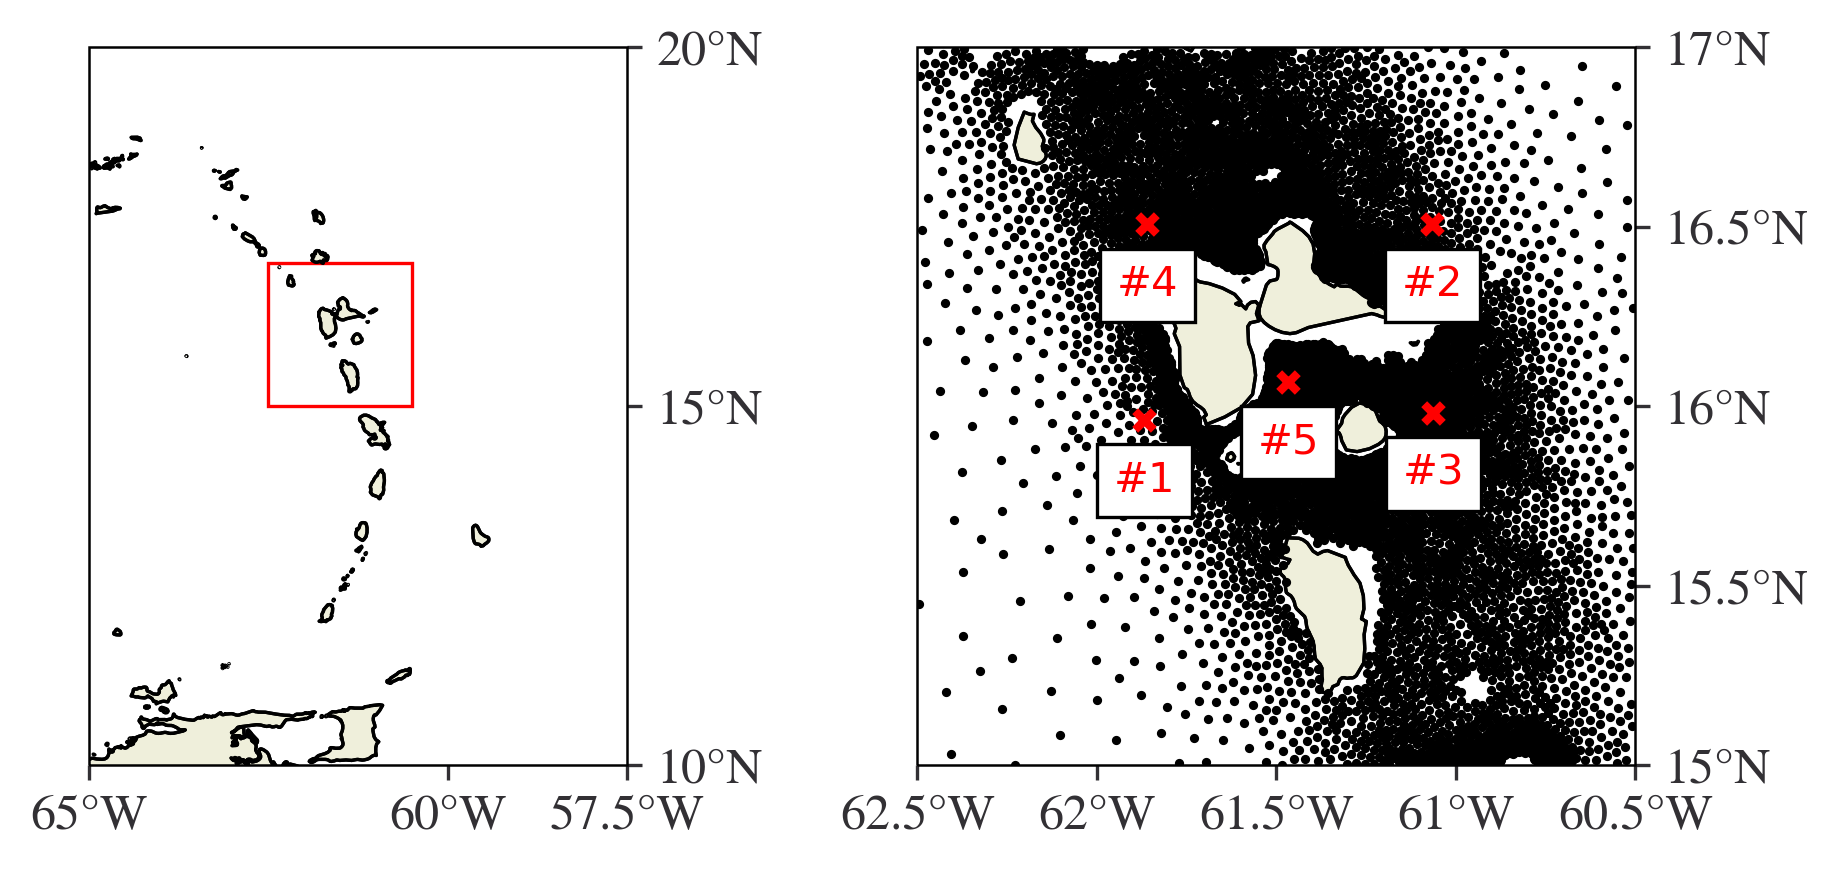

In [45]:
fig = grapher.Grapher(mstme_condition).draw(
    "General_Map_3",
    pos_list=pos_list_pwe,
    draw_fig=True,
    dir_out=dir_out,
    node_size=2,
)

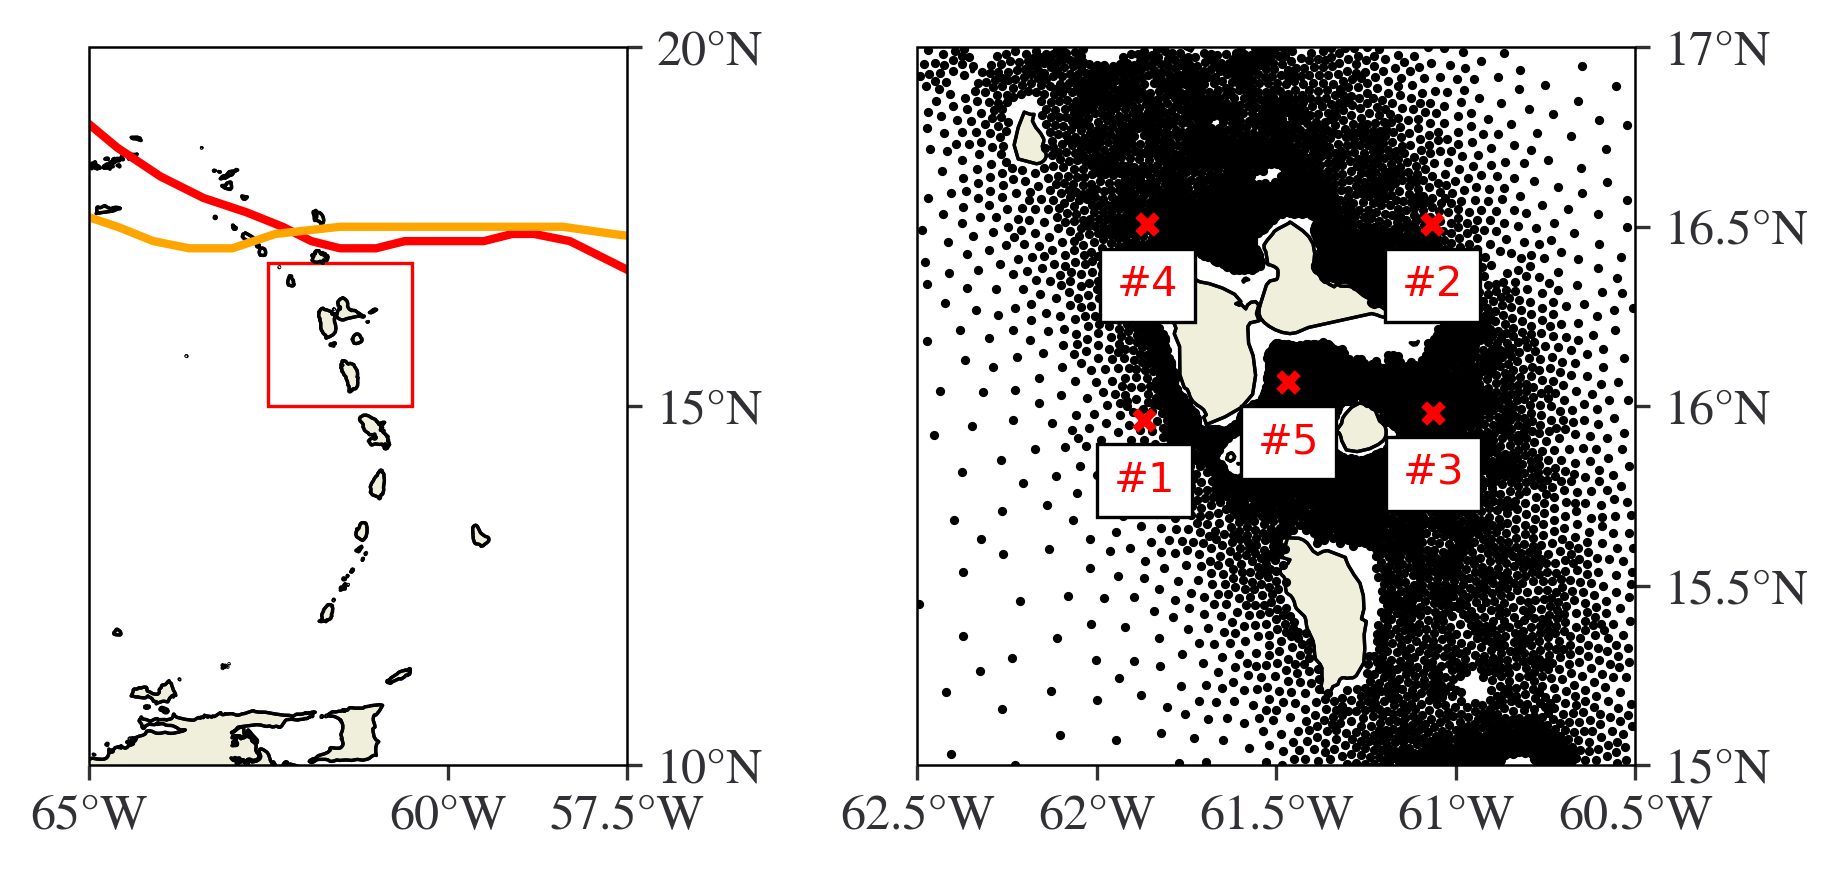

In [16]:
_ = grapher.Grapher(mstme_condition).draw(
    "General_Map_4",
    pos_list=pos_list_pwe,
    events=[0,1],
    draw_fig=True,
    dir_out=dir_out,
    node_size=2,
)

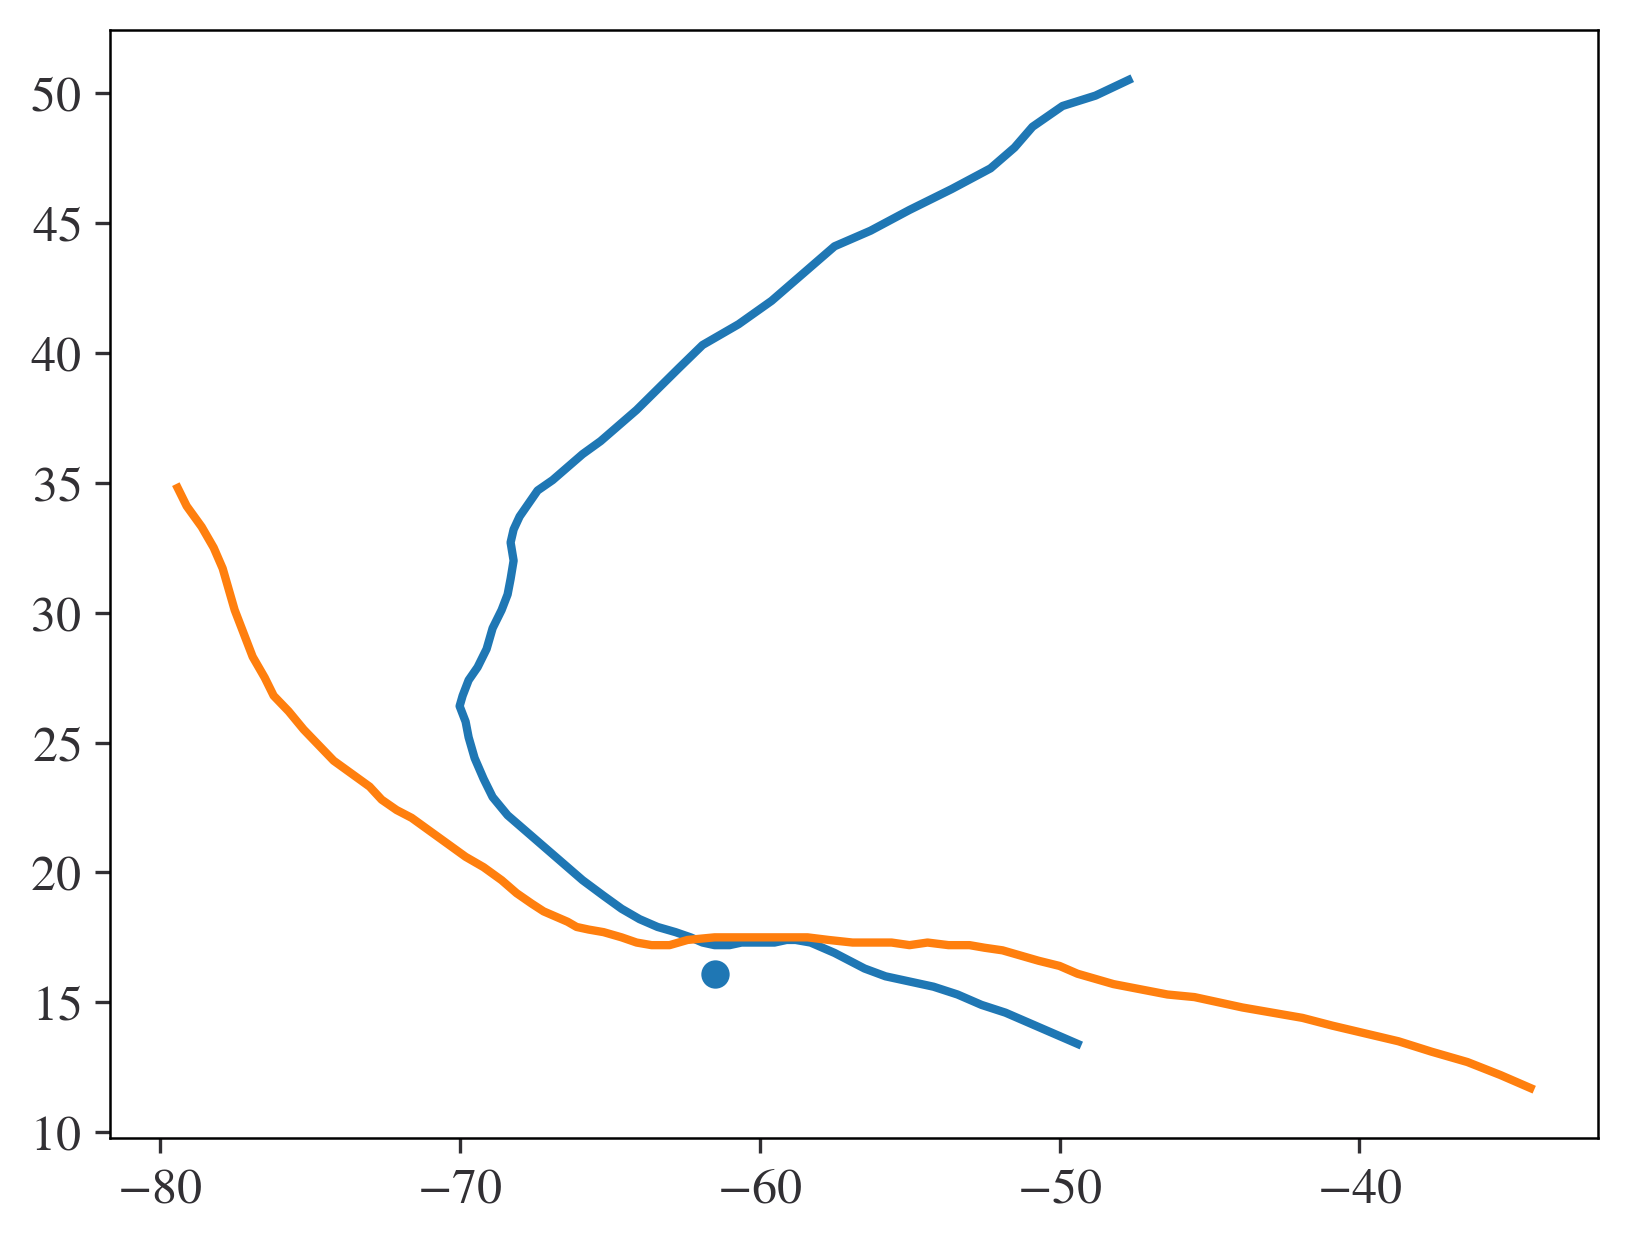

In [62]:
plt.plot(
  mstme_condition.tracks[0][:,1],
  mstme_condition.tracks[0][:,0],
)
plt.plot(
  mstme_condition.tracks[1][:,1],
  mstme_condition.tracks[1][:,0],
)
plt.scatter(-61.5,16.1)

(-62.0, -60.8) -61.86822 [0.1098156  0.20284081]
(-62.0, -60.8) -61.0656 [0.77866554 0.88333988]
(-62.0, -60.8) -61.063473 [0.78043938 0.22654438]
(-62.0, -60.8) -61.859367 [0.11719386 0.88300371]
(-62.0, -60.8) -61.466587 [0.44451078 0.33629084]


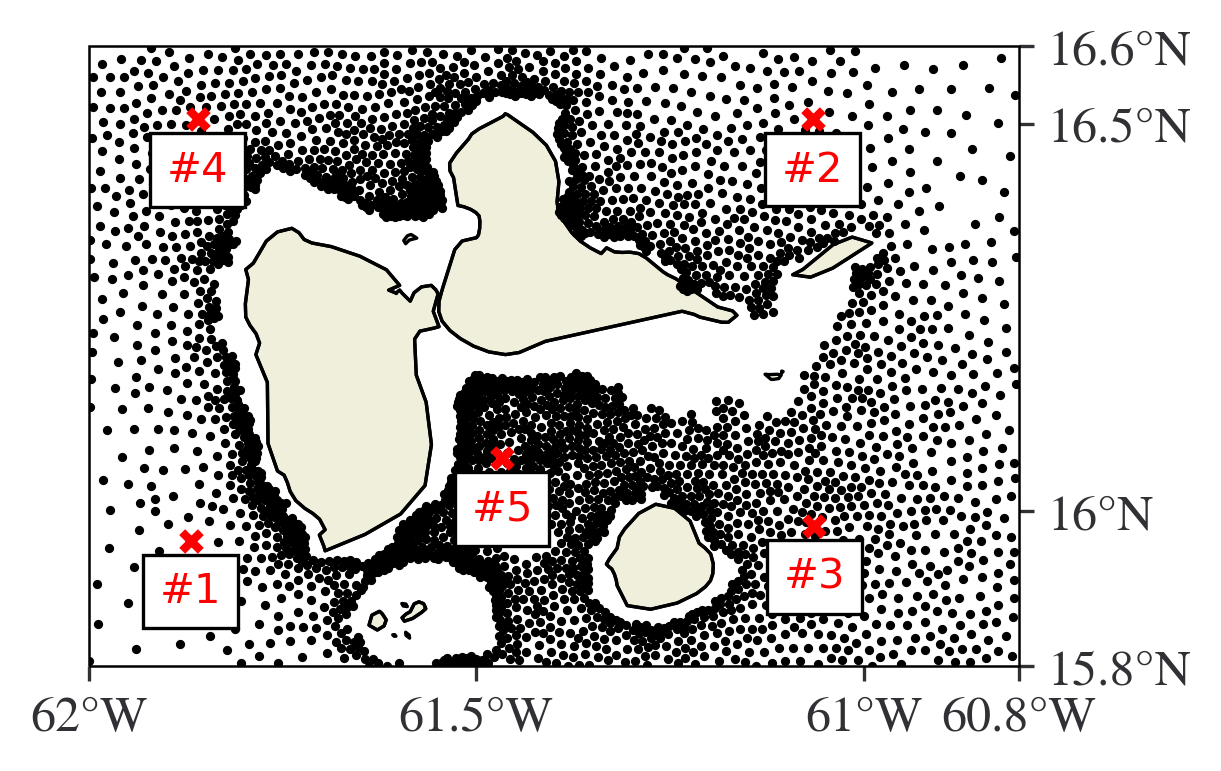

In [35]:
grapher.Grapher(mstme_condition).draw(
    "General_Map",
    pos_list=pos_list_pwe,
    draw_fig=True,
    dir_out=dir_out,
    node_size=2,
)
coord_in = np.array([[16.5,-61.8],
        [16.0,-61.9],
        [16.05,-61.4],
        [16.0,-61.0],
        [16.5,-61.1],])
# for i,coord in enumerate(coord_in):
#     plt.scatter(coord[1],coord[0],marker='x',color='red',s=20)
#     plt.text(coord[1]+0.1,coord[0],f'{i}',c='red',fontfamily='sans-serif',ha='center',bbox=dict(facecolor='white'))

In [36]:
def draw_rv(return_period):
    stm_min = [0, 0]
    stm_max = [30, 80]
    tm_original = mstme_condition.tm[:, :, pos_list_pwe]
    tm_MSTME_ss_pwe = tm_MSTME_ss[:, :, :, idx_list_pwe]

    # bi, ni, vi, ei
    assert tm_MSTME_ss_pwe.shape == tm_PWE_ss.shape
    N_subsample = tm_MSTME_ss_pwe.shape[0]
    #########################################################
    fig, axes = plt.subplots(
        2,
        3,
        figsize=(4 * 3, 3 * 2),
        facecolor="white",
    )
    # delete 6th plot because we only need 5
    fig.delaxes(axes.flat[5])

    fig.tight_layout()
    for i, ax in enumerate(axes.flatten()[:5]):
        print(i)
        ax.set_xlabel(r"$H_s$[m]")
        ax.set_ylabel(r"$U$[m/s]")
        ax.set_xlim(stm_min[0], stm_max[0])
        ax.set_ylim(stm_min[1], stm_max[1])

        # Sample count over threshold
        _num_events_sample = tm_MSTME_ss_pwe.shape[2]
        _exceedance_prob = 1 - mstme_condition.thr_pct_com
        _count_sample = round(
            _num_events_sample
            / (return_period * mstme_condition.occur_freq * _exceedance_prob)
        )
        _ic_original = []
        _num_events_original = tm_original.shape[1]
        _count_original = round(
            _num_events_original / (return_period * mstme_condition.occur_freq)
        )
        exceedance_prob_com_PWE = 1 - 0.7
        exceedance_prob = 1 / (
            return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE
        )
        _count_sample_PWE = round(
            _num_events_sample
            / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
        )
        # Bootstraps
        ic_MSTME = grapher._search_isocontours(
            tm_MSTME_ss_pwe[:, :, :, i], _count_sample
        )

        ic_PWE = grapher._search_isocontours(tm_PWE_ss[:, :, :, i], _count_sample_PWE)

        res_band = 51
        ic_band_MSTME_u, ic_band_MSTME_l, ic_band_MSTME_m = grapher._get_interp_band(
            ic_MSTME,
            scale=stm_max[1] / stm_max[0],
            res=res_band,
        )
        ic_band_PWE_u, ic_band_PWE_l, ic_band_PWE_m = grapher._get_interp_band(
            ic_PWE,
            scale=stm_max[1] / stm_max[0],
            res=res_band,
        )

        # MSTME
        ax.plot(
            ic_band_MSTME_u[0],
            ic_band_MSTME_u[1],
            c=grapher.pos_color[0],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_MSTME_l[0],
            ic_band_MSTME_l[1],
            c=grapher.pos_color[0],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_MSTME_m[0],
            ic_band_MSTME_m[1],
            c=grapher.pos_color[0],
            lw=2,
            label="MSTME",
        )

        # MSTME
        ax.plot(
            ic_band_PWE_u[0],
            ic_band_PWE_u[1],
            c=grapher.pos_color[1],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_PWE_l[0],
            ic_band_PWE_l[1],
            c=grapher.pos_color[1],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_PWE_m[0],
            ic_band_PWE_m[1],
            c=grapher.pos_color[1],
            lw=2,
            label="PWE",
        )

        # Original
        _ic_original = grapher._search_isocontour(tm_original[:, :, i], _count_original)

        ax.scatter(
            tm_original[0, :, i],
            tm_original[1, :, i],
            s=10,
            c="black",
            label=f"Original temporal maxima",
            # marker="x",
        )
        ax.plot(
            _ic_original[0],
            _ic_original[1],
            c="black",
            lw=2,
            label=f"Empirical {return_period}-yr RV",
        )
        ax.set_title(f"Location {i+1}")
        # if i == 0:
        #     ax.legend()
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_sideways.pdf",
        bbox_inches="tight",
    )
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_sideways.png",
        bbox_inches="tight",
    )


def draw_rv2(return_period, **kwargs):
    stm_min = [0, 0]
    stm_max = [25, 60]
    tm_original = mstme_condition.tm[:, :, pos_list_pwe]
    tm_MSTME_ss_pwe = tm_MSTME_ss[:, :, :, idx_list_pwe]

    # bi, ni, vi, ei
    assert tm_MSTME_ss_pwe.shape == tm_PWE_ss.shape
    N_subsample = tm_MSTME_ss_pwe.shape[0]
    #########################################################
    fig, axes = plt.subplots(
        2,
        3,
        figsize=(8 * 3, 6 * 2),
        facecolor="white",
    )
    # delete 6th plot because we only need 5
    fig.delaxes(axes.flat[5])

    fig.tight_layout()
    # for i, ax in enumerate(axes.flatten()[:5]):
    for i, ax in enumerate(axes.flatten()[:1]):
        print(i)
        ax.set_xlabel(r"$H_s$[m]")
        ax.set_ylabel(r"$U$[m/s]")
        ax.set_xlim(stm_min[0], stm_max[0])
        ax.set_ylim(stm_min[1], stm_max[1])

        # Sample count over threshold
        _num_events_sample = tm_MSTME_ss_pwe.shape[2]
        _exceedance_prob = 1 - mstme_condition.thr_pct_com
        _count_sample = round(
            _num_events_sample
            / (return_period * mstme_condition.occur_freq * _exceedance_prob)
        )
        _ic_original = []
        _num_events_original = tm_original.shape[1]
        _count_original = round(
            _num_events_original / (return_period * mstme_condition.occur_freq)
        )
        exceedance_prob_com_PWE = 1 - 0.7
        exceedance_prob = 1 / (
            return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE
        )
        _count_sample_PWE = round(
            _num_events_sample
            / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
        )
        # Bootstraps
        ic_MSTME = kwargs.get(
            "is_MSTME",
            grapher._search_isocontours(tm_MSTME_ss_pwe[:, :, :, i], _count_sample),
        )
        ic_PWE = kwargs.get(
            "ic_PWE",
            grapher._search_isocontours(tm_PWE_ss[:, :, :, i], _count_sample_PWE),
        )
        res_band = 51
        ic_band_MSTME_u, ic_band_MSTME_l, ic_band_MSTME_m = grapher._get_interp_band(
            ic_MSTME,
            scale=stm_max[1] / stm_max[0],
            res=res_band,
        )
        ic_band_PWE_u, ic_band_PWE_l, ic_band_PWE_m = grapher._get_interp_band(
            ic_PWE,
            scale=stm_max[1] / stm_max[0],
            res=res_band,
        )

        # MSTME
        ic_band_MSTME_l_trunc = grapher._trunc_band(ic_band_MSTME_l)
        ic_band_MSTME_m_trunc = grapher._trunc_band(ic_band_MSTME_m)
        ic_band_MSTME_u_trunc = grapher._trunc_band(ic_band_MSTME_u)
        ax.plot(
            ic_band_MSTME_u_trunc[0],
            ic_band_MSTME_u_trunc[1],
            c=grapher.pos_color[0],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_MSTME_l_trunc[0],
            ic_band_MSTME_l_trunc[1],
            c=grapher.pos_color[0],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_MSTME_m_trunc[0],
            ic_band_MSTME_m_trunc[1],
            c=grapher.pos_color[0],
            lw=2,
            label="MSTME",
        )

        # PWE
        ic_band_PWE_l_trunc = grapher._trunc_band(ic_band_PWE_l)
        ic_band_PWE_m_trunc = grapher._trunc_band(ic_band_PWE_m)
        ic_band_PWE_u_trunc = grapher._trunc_band(ic_band_PWE_u)
        ax.plot(
            ic_band_PWE_u_trunc[0],
            ic_band_PWE_u_trunc[1],
            c=grapher.pos_color[1],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_PWE_l_trunc[0],
            ic_band_PWE_l_trunc[1],
            c=grapher.pos_color[1],
            lw=2,
            ls="--",
        )
        ax.plot(
            ic_band_PWE_m_trunc[0],
            ic_band_PWE_m_trunc[1],
            c=grapher.pos_color[1],
            lw=2,
            label="PWE",
        )

        # Original
        _ic_original = grapher._search_isocontour(tm_original[:, :, i], _count_original)

        ax.scatter(
            tm_original[0, :, i],
            tm_original[1, :, i],
            s=10,
            c="black",
            label=f"Samples",
            marker="x",
        )
        ax.plot(
            _ic_original[0],
            _ic_original[1],
            c="black",
            lw=2,
            label=f"Empirical {return_period}-yr RV",
        )
        ax.set_title(f"Location {i+1}")
        if i == 0:
            ax.legend()
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_separated.pdf",
        bbox_inches="tight",
    )
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_separated.png",
        bbox_inches="tight",
    )

0
1
2
3
4


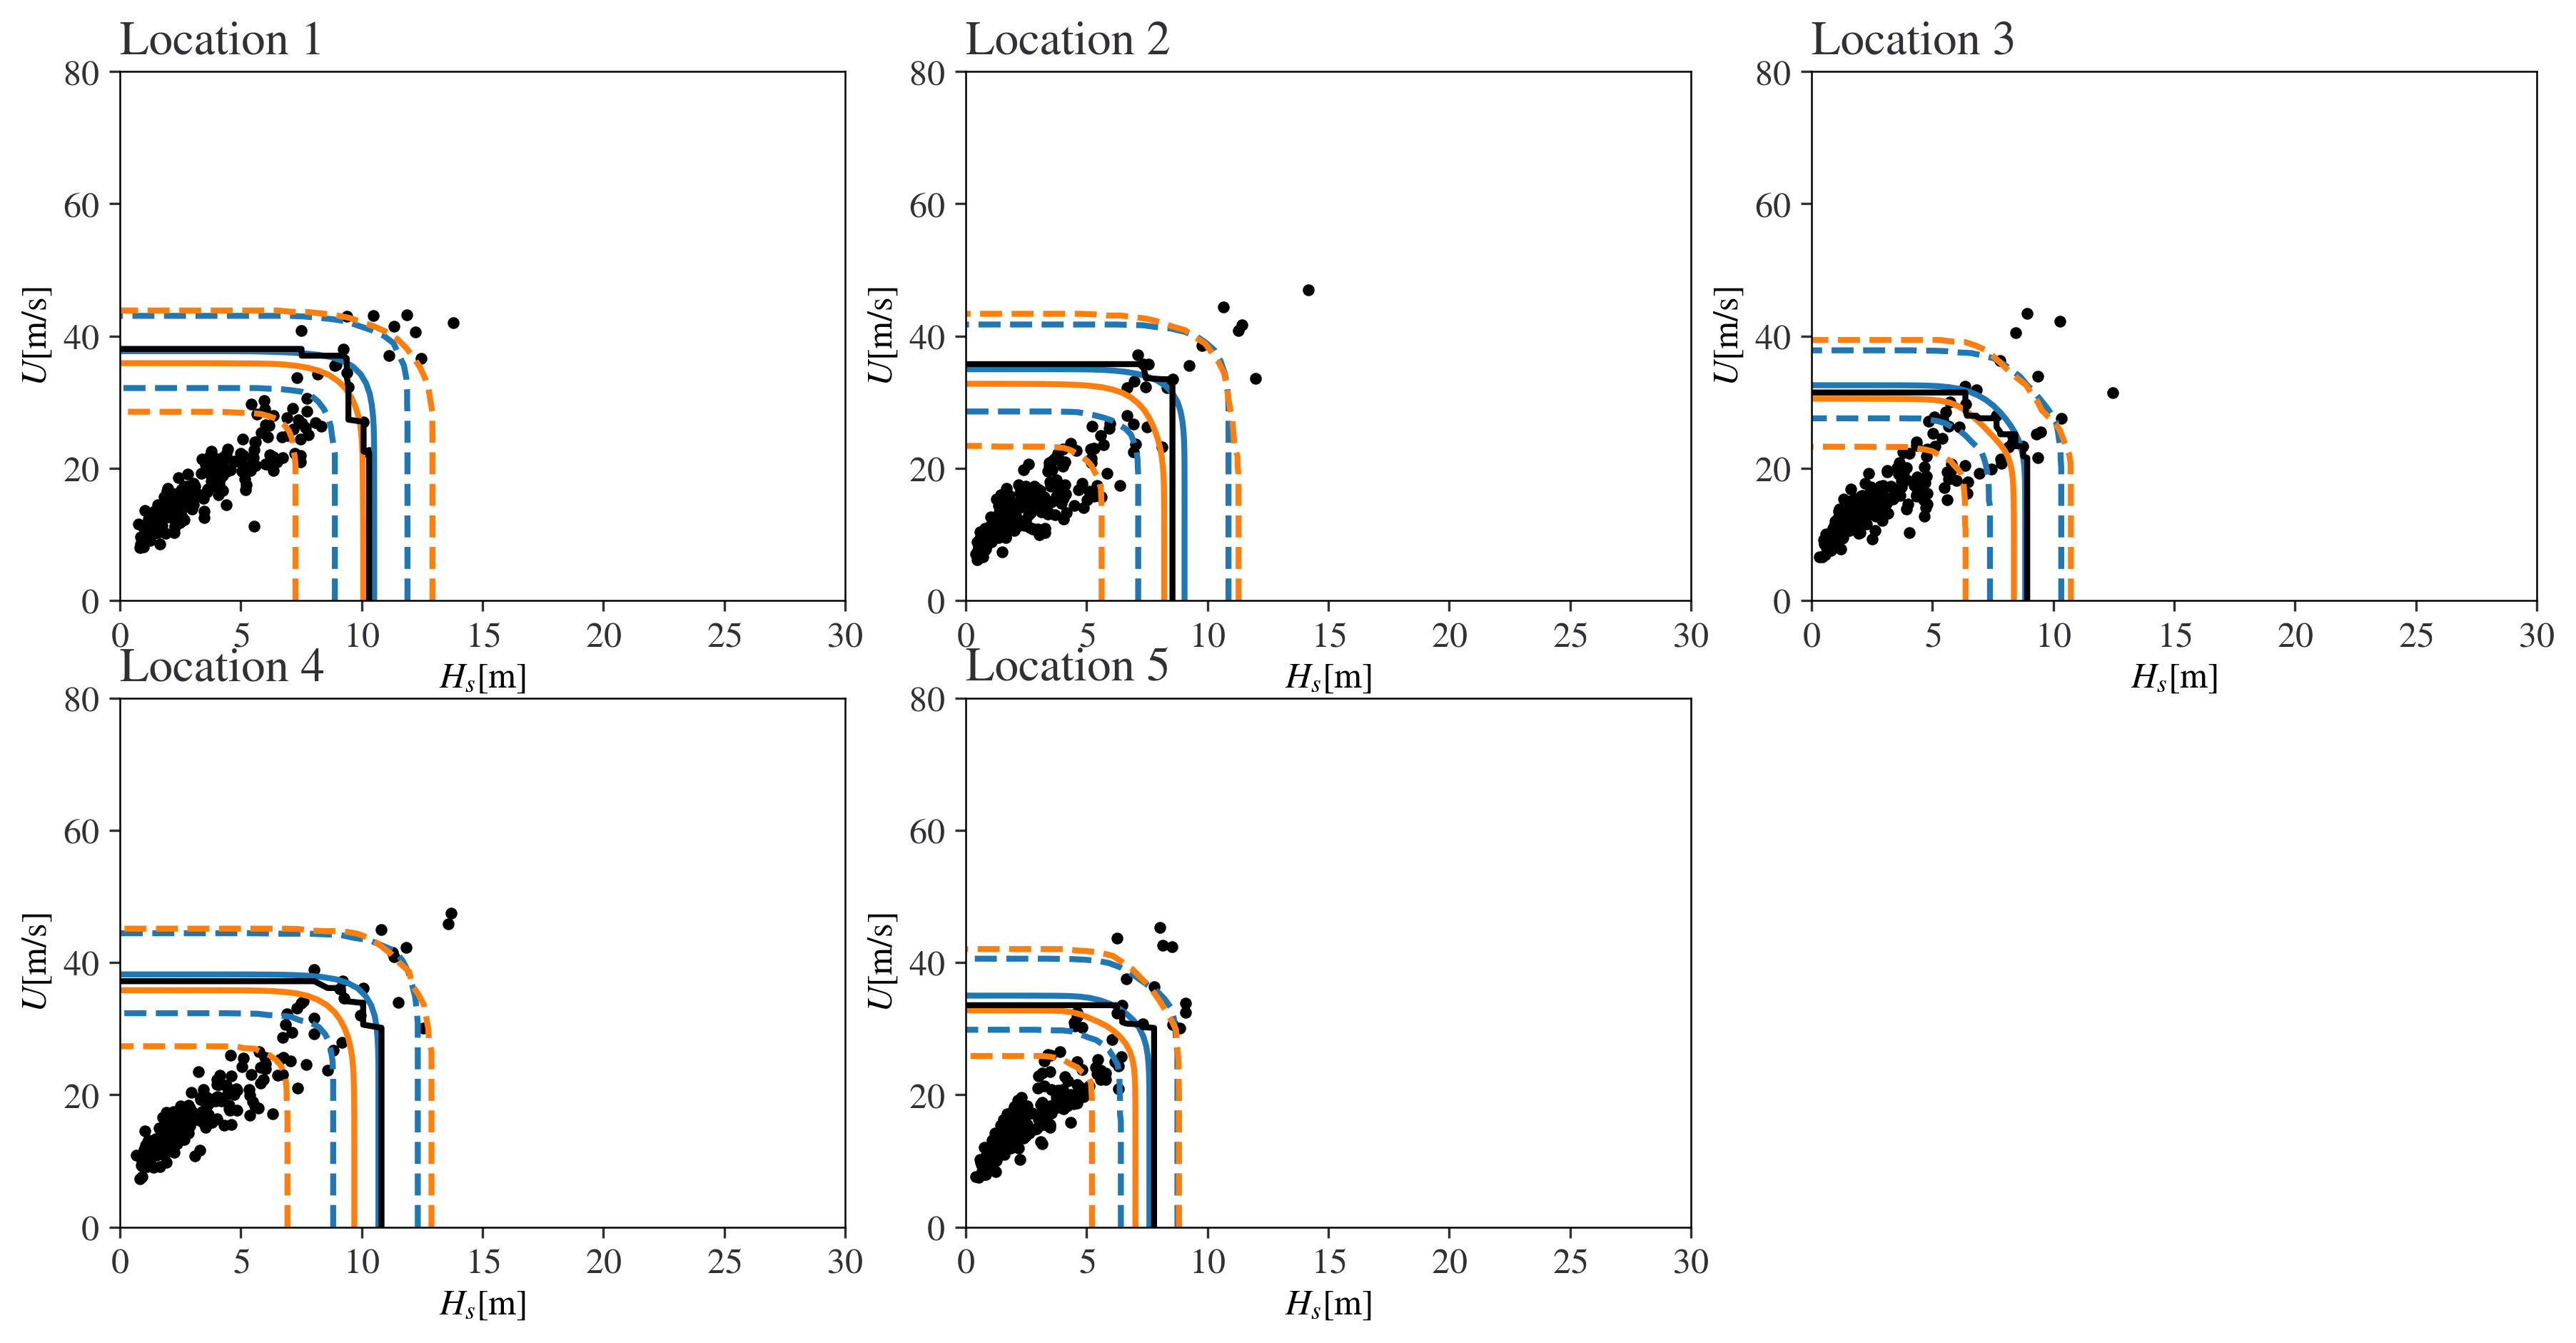

In [37]:
draw_rv(return_period=100)

0
1
2
3
4


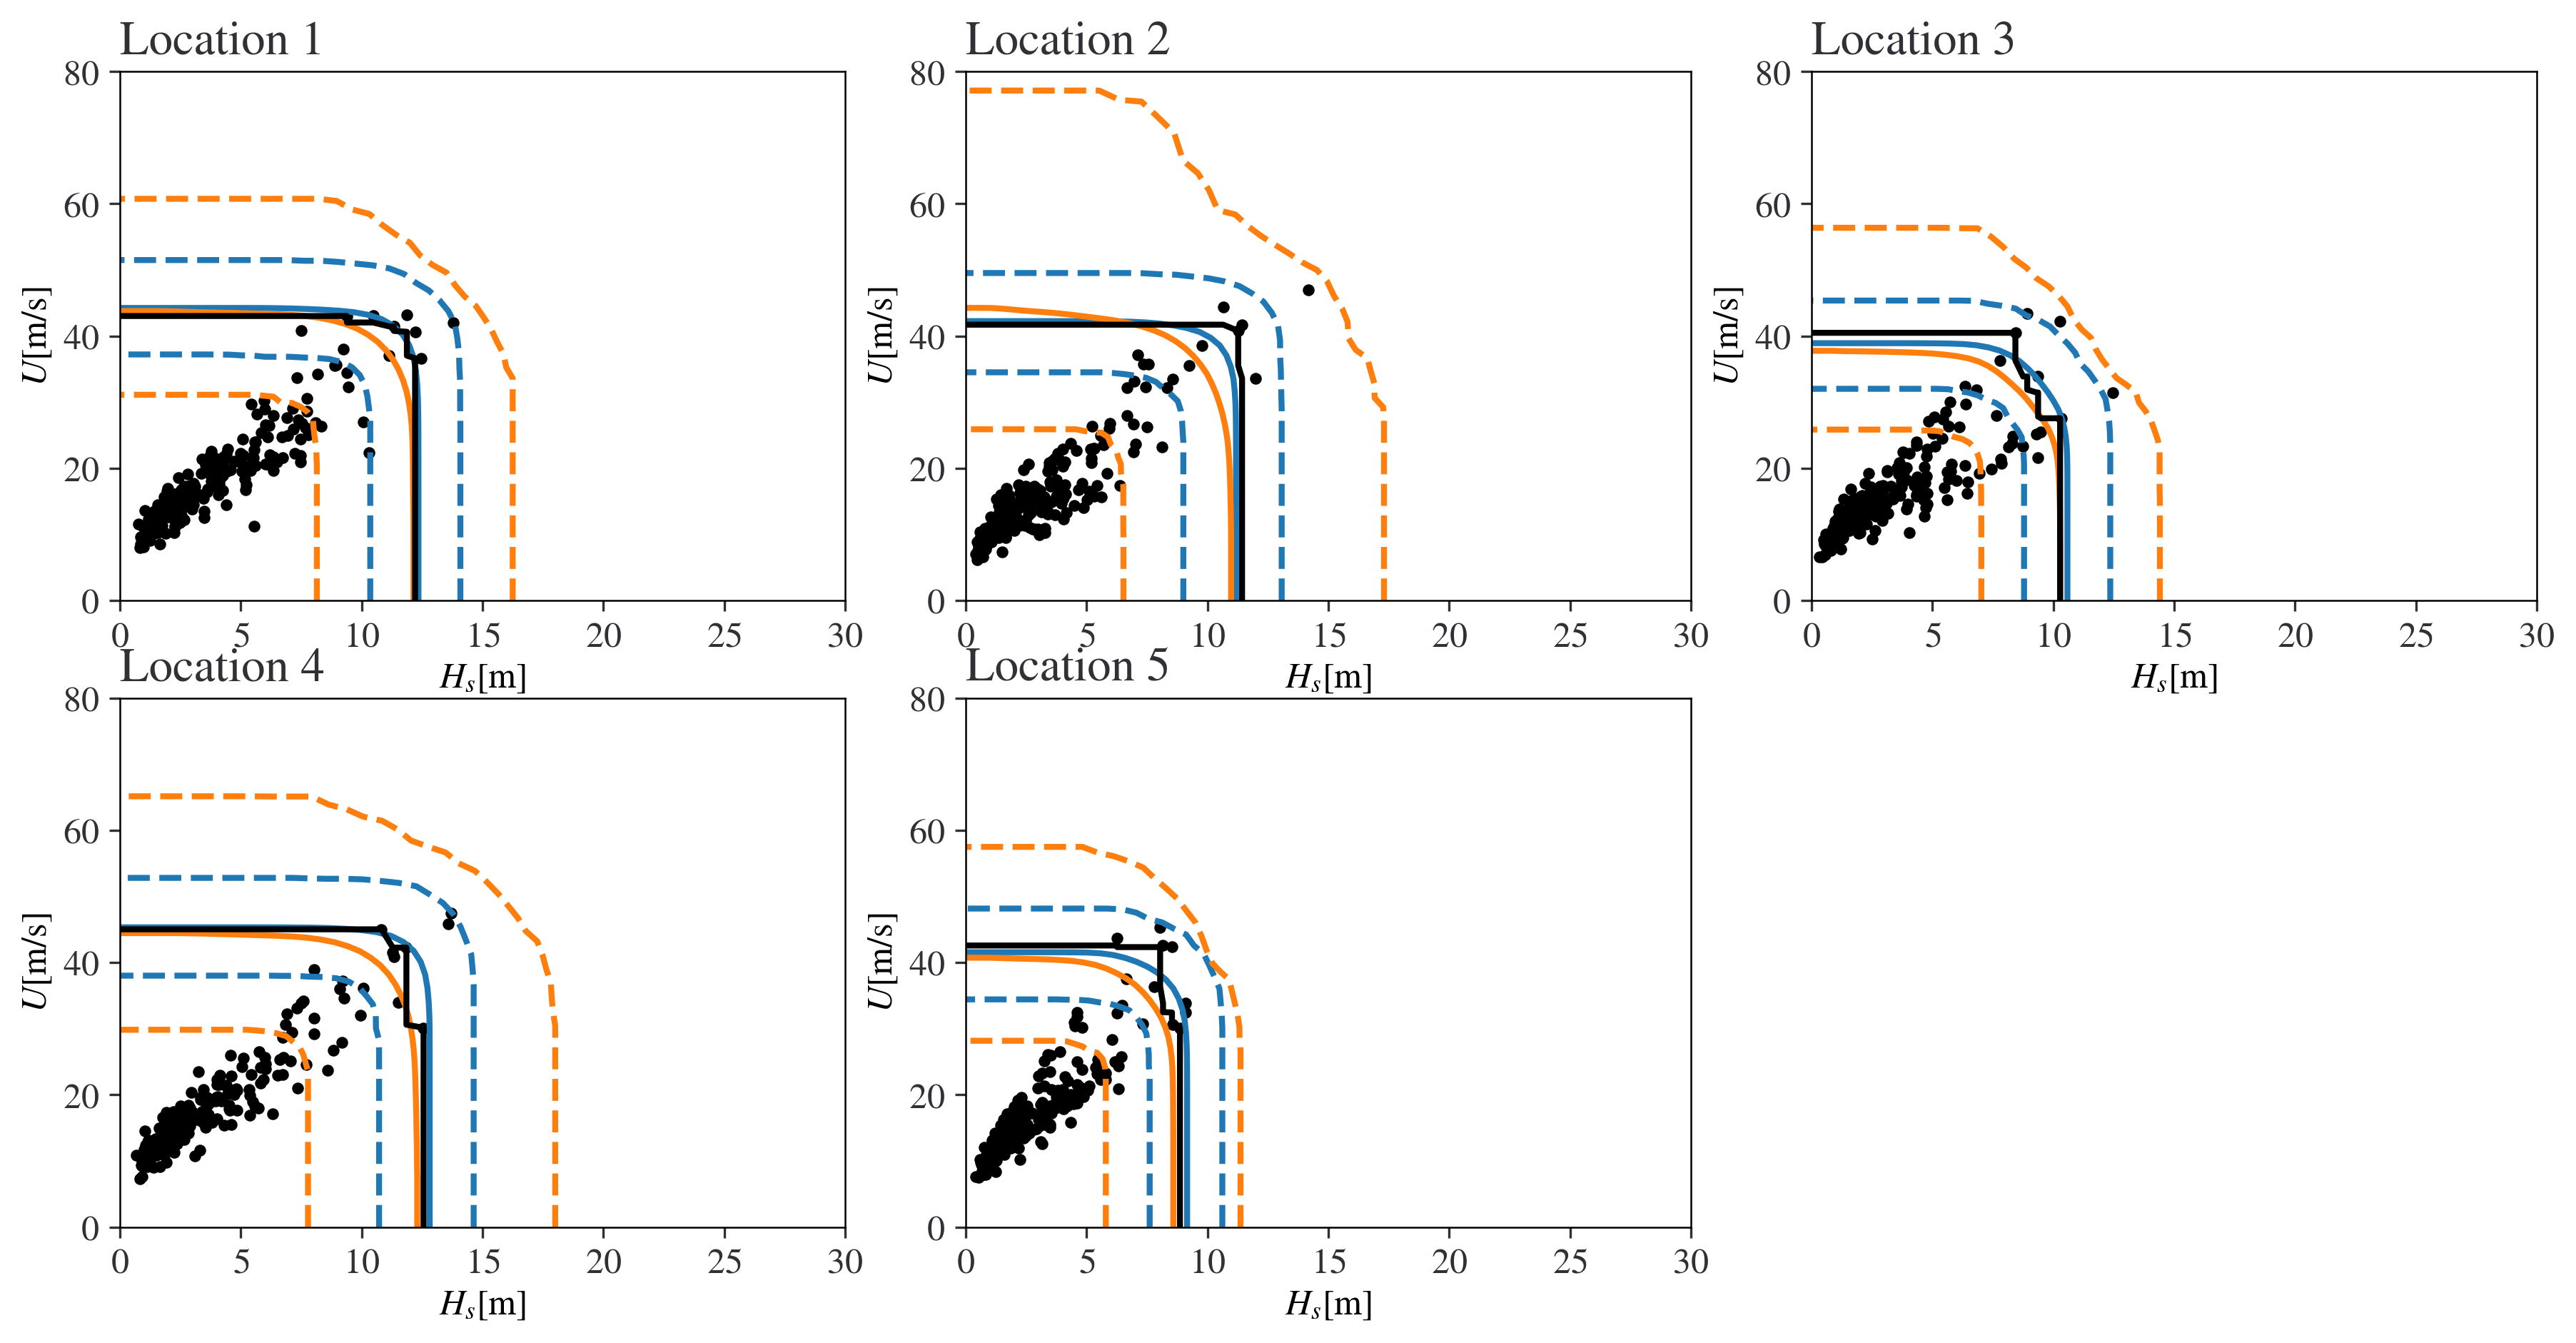

In [38]:
draw_rv(return_period=300)
  

## Normalized

In [44]:
def calculate_normalized(return_period):
    stm_min = [0, 0]
    stm_max = [30, 80]
    tm_original = mstme_condition.tm[:, :, pos_list_pwe]
    tm_MSTME_ss_pwe = tm_MSTME_ss[:, :, :, idx_list_pwe]

    tm_MSTME_ss_norm = np.empty(tm_MSTME_ss_pwe.shape)  # (ss,v,e,n)
    tm_PWE_ss_norm = np.empty(tm_PWE_ss.shape)  # (ss,v,e,n)
    tm_original_norm = np.empty(tm_original.shape)  # (ss,v,e,n)
    for S in STM:
        vi = S.idx()
        tm_MSTME_ss_norm[:, vi, :, :] = np.clip(
            mstme_condition.ndist.ppf(
                mstme_condition.mix_dist[vi].cdf(tm_MSTME_ss_pwe[:, vi, :, :])
            ),
            -10,
            10,
        )
        tm_PWE_ss_norm[:, vi, :, :] = np.clip(
            mstme_condition.ndist.ppf(
                mstme_condition.mix_dist[vi].cdf(tm_PWE_ss[:, vi, :, :])
            ),
            -10,
            10,
        )
        tm_original_norm[vi, :, :] = np.clip(
            mstme_condition.ndist.ppf(
                mstme_condition.mix_dist[vi].cdf(tm_original[vi, :, :])
            ),
            -10,
            10,
        )

    # bi, ni, vi, ei
    assert tm_MSTME_ss_pwe.shape == tm_PWE_ss.shape
    N_subsample = tm_MSTME_ss_pwe.shape[0]
    #########################################################

    _num_events_sample = tm_MSTME_ss_norm.shape[2]
    _exceedance_prob = 1 - mstme_condition.thr_pct_com
    _count_sample = round(
        _num_events_sample
        / (return_period * mstme_condition.occur_freq * _exceedance_prob)
    )
    exceedance_prob_com_PWE = 1 - 0.7
    exceedance_prob = 1 / (
        return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE
    )
    _count_sample_PWE = round(
        _num_events_sample
        / (return_period * mstme_condition.occur_freq * exceedance_prob_com_PWE)
    )
    _ic_original = []
    _num_events_original = tm_original.shape[1]
    _count_original = round(
        _num_events_original / (return_period * mstme_condition.occur_freq)
    )

    l_array_MSTME = []
    l_array_PWE = []
    l_array_original = []
    for i in range(len(pos_list_pwe)):
        print(i)
        # ax.set_xlabel(r"$H_s$[m]")
        # ax.set_ylabel(r"$U$[m/s]")
        # ax.set_xlim(stm_min[0], stm_max[0])
        # ax.set_ylim(stm_min[1], stm_max[1])
        # # Sample count over threshold
        # Bootstraps
        ic_MSTME = grapher._search_isocontours(
            tm_MSTME_ss_norm[:, :, :, i], _count_sample
        )
        ic_PWE = grapher._search_isocontours(
            tm_PWE_ss_norm[:, :, :, i], _count_sample_PWE
        )
        ic_original = grapher._search_isocontour(
            tm_original_norm[:, :, i], _count_original
        )
        l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME, scale=1))
        l_array_PWE.append(grapher._get_interp_band_diag(ic_PWE, scale=1))
        l_array_original.append(grapher._get_interp_band_diag([ic_original], scale=1))
    l_array_MSTME = np.array(l_array_MSTME)
    l_array_PWE = np.array(l_array_PWE)
    l_array_original = np.array(l_array_original)
    bias_MSTME = np.mean(l_array_MSTME - l_array_original, axis=1)
    var_MSTME = np.var(l_array_MSTME, axis=1)
    bias_PWE = np.mean(l_array_PWE - l_array_original, axis=1)
    var_PWE = np.var(l_array_PWE, axis=1)
    ###################################################
    # --- Combining your data:
    data_group1 = l_array_MSTME.tolist()
    data_group2 = l_array_PWE.tolist()

    colors = [grapher.pos_color[0], grapher.pos_color[1]]

    # we compare the performances of the 2 individuals within the same set of 5 settings
    data_groups = [data_group1, data_group2]

    # --- Labels for your data:
    labels_list = [f"#{i}" for i in range(1, 1 + len(pos_list_pwe))]
    width = 1 / len(labels_list)
    xlocations = [x * ((1 + len(data_groups)) * width) for x in range(len(data_group1))]

    symbol = "k+"
    ymin = min([val for dg in data_groups for data in dg for val in data])
    ymax = max([val for dg in data_groups for data in dg for val in data])

    ax = plt.gca()
    ax.set_ylim(ymin, ymax)

    ax.grid(True, linestyle="dotted")
    ax.set_axisbelow(True)

    plt.xlabel("Location")
    plt.ylabel("Distance from origin on Laplace scale")
    # plt.title(f"Joint performance:{rf}")

    space = len(data_groups) / 2
    offset = len(data_groups) / 2

    # --- Offset the positions per group:

    group_positions = []
    for num, dg in enumerate(data_groups):
        _off = 0 - space + (0.5 + num)
        print(_off)
        group_positions.append([x + _off * (width + 0.01) for x in xlocations])

    for dg, pos, c in zip(data_groups, group_positions, colors):
        boxes = ax.boxplot(
            dg,
            sym=symbol,
            labels=[""] * len(labels_list),
            #            labels=labels_list,
            positions=pos,
            widths=width,
            boxprops=dict(facecolor=c),
            #             capprops=dict(color=c),
            #            whiskerprops=dict(color=c),
            #            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="k",ls='--'),
            #           notch=False,
            #           vert=True,
            #           whis=1.5,
            #           bootstrap=None,
            #           usermedians=None,
            #           conf_intervals=None,
            patch_artist=True,
        )
    ax.set_xticks(xlocations)
    ax.set_xticklabels(labels_list, rotation=0)

    for i in range(len(pos_list_pwe)):
        ax.hlines(
            l_array_original[i],
            xlocations[i] - width,
            xlocations[i] + width,
            color="k",
            lw=3,
            zorder=10,
        )

    # custom_lines = [
    #     mpatches.Patch(color=colors[0]),
    #     mpatches.Patch(color=colors[1]),
    #     Line2D([0], [0], color="r"),
    # ]

    # # ax.legend(custom_lines, [f'{thr:.2f}'for thr in thr_com_list])
    # ax.legend(custom_lines, ["MSTME", "PWE", "Empirical"])
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_joint.pdf",
        bbox_inches="tight",
    )
    plt.savefig(
        dir_out / f"RV_comparison_5locations_{return_period}_joint.png",
        bbox_inches="tight",
    )
    plt.show()

    # ###########################################################
    # print(f"Cluster:{rf}, RP:{return_period}")
    # # print(f"Empirical:\t{l_array_original.squeeze()}")
    # mstme_diff = np.round(np.median(l_array_MSTME,axis=1) -l_array_original.squeeze(),3)
    # mstme_var = np.round(np.var(l_array_MSTME,axis=1),3)
    # pwe_diff = np.round(np.median(l_array_PWE,axis=1) -l_array_original.squeeze(),3)
    # pwe_var = np.round(np.var(l_array_PWE,axis=1),3)
    # print(f"MSTME:\t\t{mstme_diff}")
    # print(f"\t\tMean:{np.round(mstme_diff.mean(),3)}")
    # print(f"PWE:\t\t{pwe_diff}")
    # print(f"\t\tMean:{np.round(pwe_diff.mean(),3)}")

    # ###########################################################
    # cluster= []
    # method=[]
    # l1,l2,l3,l4,l5,avg=[],[],[],[],[],[]

    # d = {
    #     "Cluster": cluster,
    #     "Method": method,
    #     "Loc.1": l1,
    #     "Loc.2": l2,
    #     "Loc.3": l3,
    #     "Loc.4": l4,
    #     "Loc.5": l5,
    #     "Avg.": avg,
    # }
    # df=pd.DataFrame(data=d)
    # df=df.append({
    #     "Cluster": rf,
    #     "Method": 'MSTM-E',
    #     "Loc.1": mstme_diff[0],
    #     "Loc.2": mstme_diff[1],
    #     "Loc.3": mstme_diff[2],
    #     "Loc.4": mstme_diff[3],
    #     "Loc.5": mstme_diff[4],
    #     "Avg.": np.round(mstme_diff.mean(),3),
    # },ignore_index=True)
    # df=df.append({
    #     "Cluster": rf,
    #     "Method": 'PWE',
    #     "Loc.1": pwe_diff[0],
    #     "Loc.2": pwe_diff[1],
    #     "Loc.3": pwe_diff[2],
    #     "Loc.4": pwe_diff[3],
    #     "Loc.5": pwe_diff[4],
    #     "Avg.": np.round(pwe_diff.mean(),3),
    # },ignore_index=True)
    # df
    # df.to_csv(dir_out/f"bias_{return_period}_5locations.csv")
    # ###########################################################
    # cluster= []
    # method=[]
    # l1,l2,l3,l4,l5,avg=[],[],[],[],[],[]

    # d = {
    #     "Cluster": cluster,
    #     "Method": method,
    #     "Loc.1": l1,
    #     "Loc.2": l2,
    #     "Loc.3": l3,
    #     "Loc.4": l4,
    #     "Loc.5": l5,
    #     "Avg.": avg,
    # }
    # df=pd.DataFrame(data=d)
    # df=df.append({
    #     "Cluster": rf,
    #     "Method": 'MSTM-E',
    #     "Loc.1": mstme_var[0],
    #     "Loc.2": mstme_var[1],
    #     "Loc.3": mstme_var[2],
    #     "Loc.4": mstme_var[3],
    #     "Loc.5": mstme_var[4],
    #     "Avg.": np.round(mstme_var.mean(),3),
    # },ignore_index=True)
    # df=df.append({
    #     "Cluster": rf,
    #     "Method": 'PWE',
    #     "Loc.1": pwe_var[0],
    #     "Loc.2": pwe_var[1],
    #     "Loc.3": pwe_var[2],
    #     "Loc.4": pwe_var[3],
    #     "Loc.5": pwe_var[4],
    #     "Avg.": np.round(pwe_var.mean(),3),
    # },ignore_index=True)
    # df
    # df.to_csv(dir_out/f"variance_{return_period}_5locations.csv")

In [22]:
calculate_normalized(100)

NameError: name 'calculate_normalized' is not defined

0
1
2
3
4
-0.5
0.5


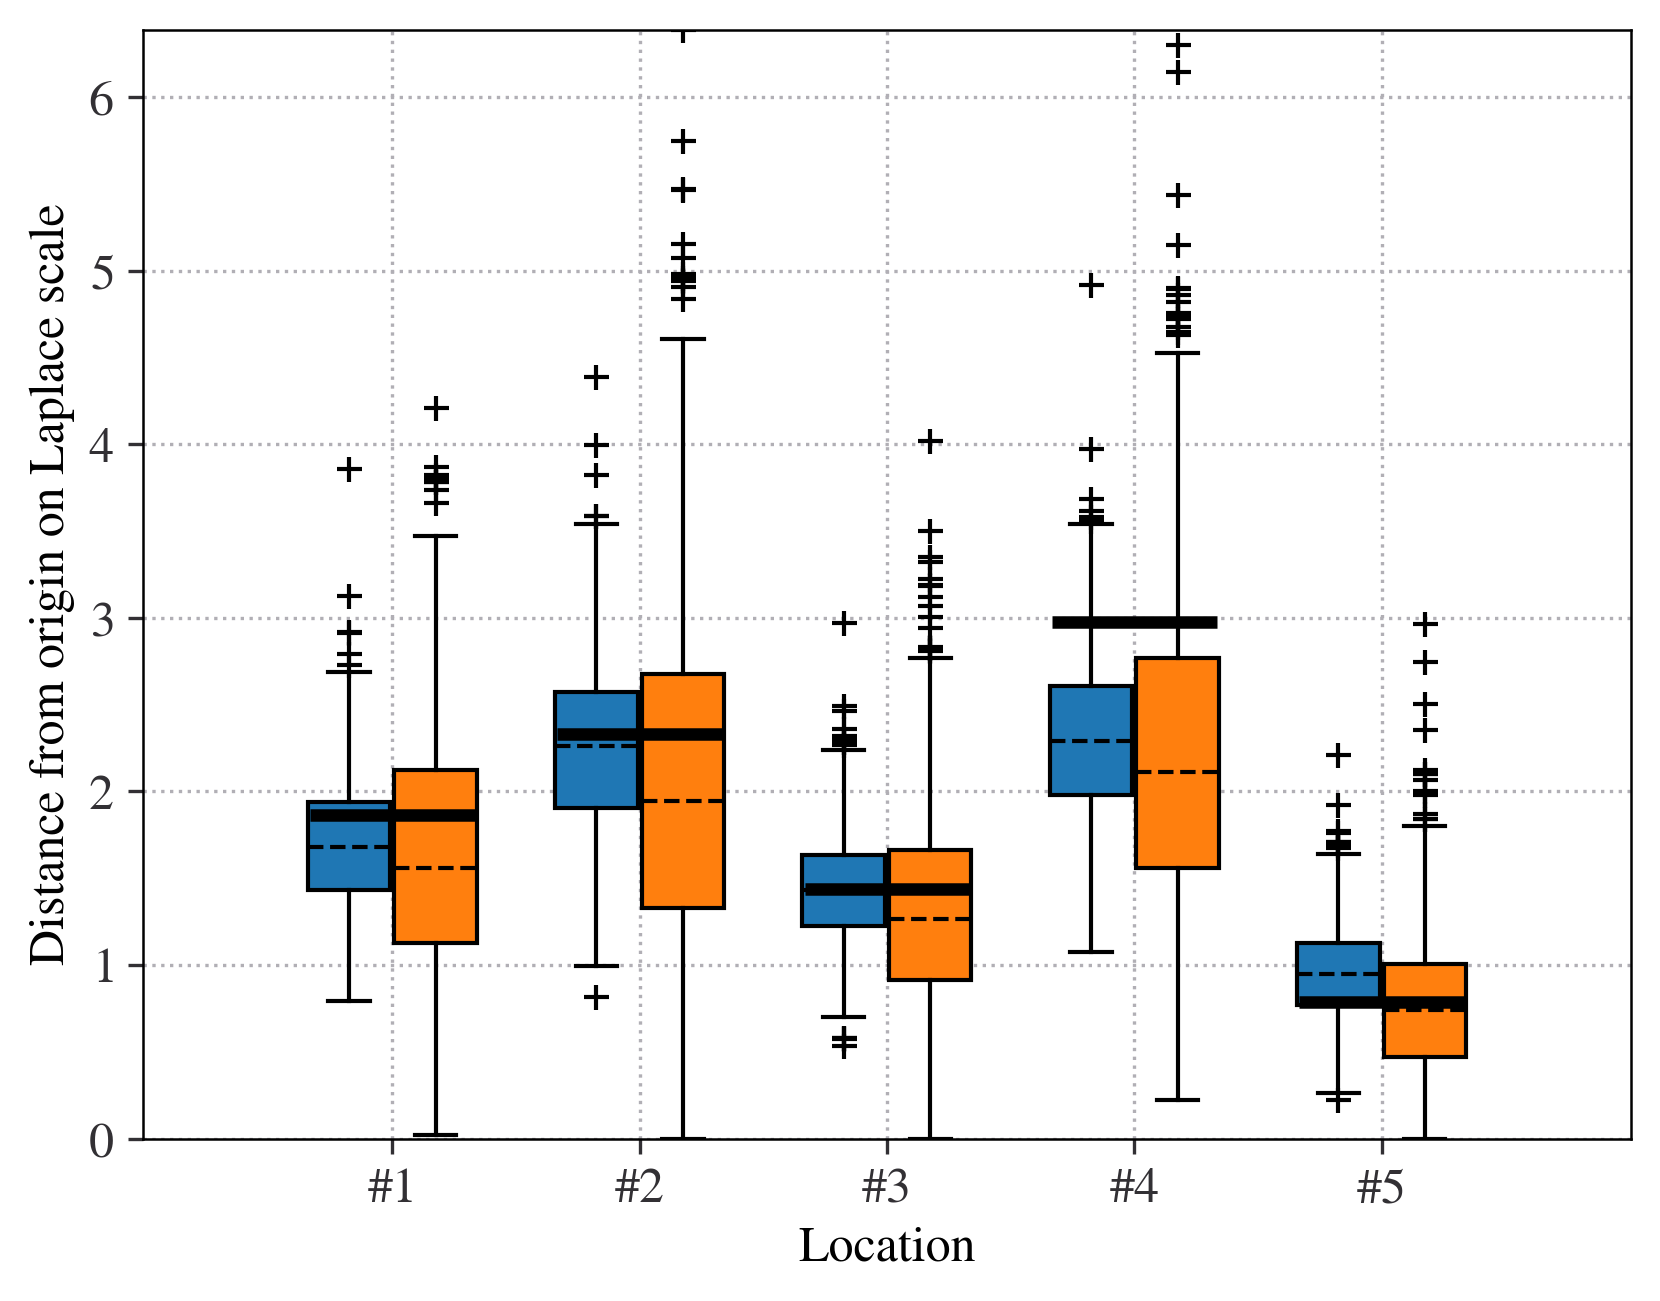

In [ ]:
calculate_normalized(300)


Text(0.0, 1.0, 'Visual example of how bias/variance is being calculated')

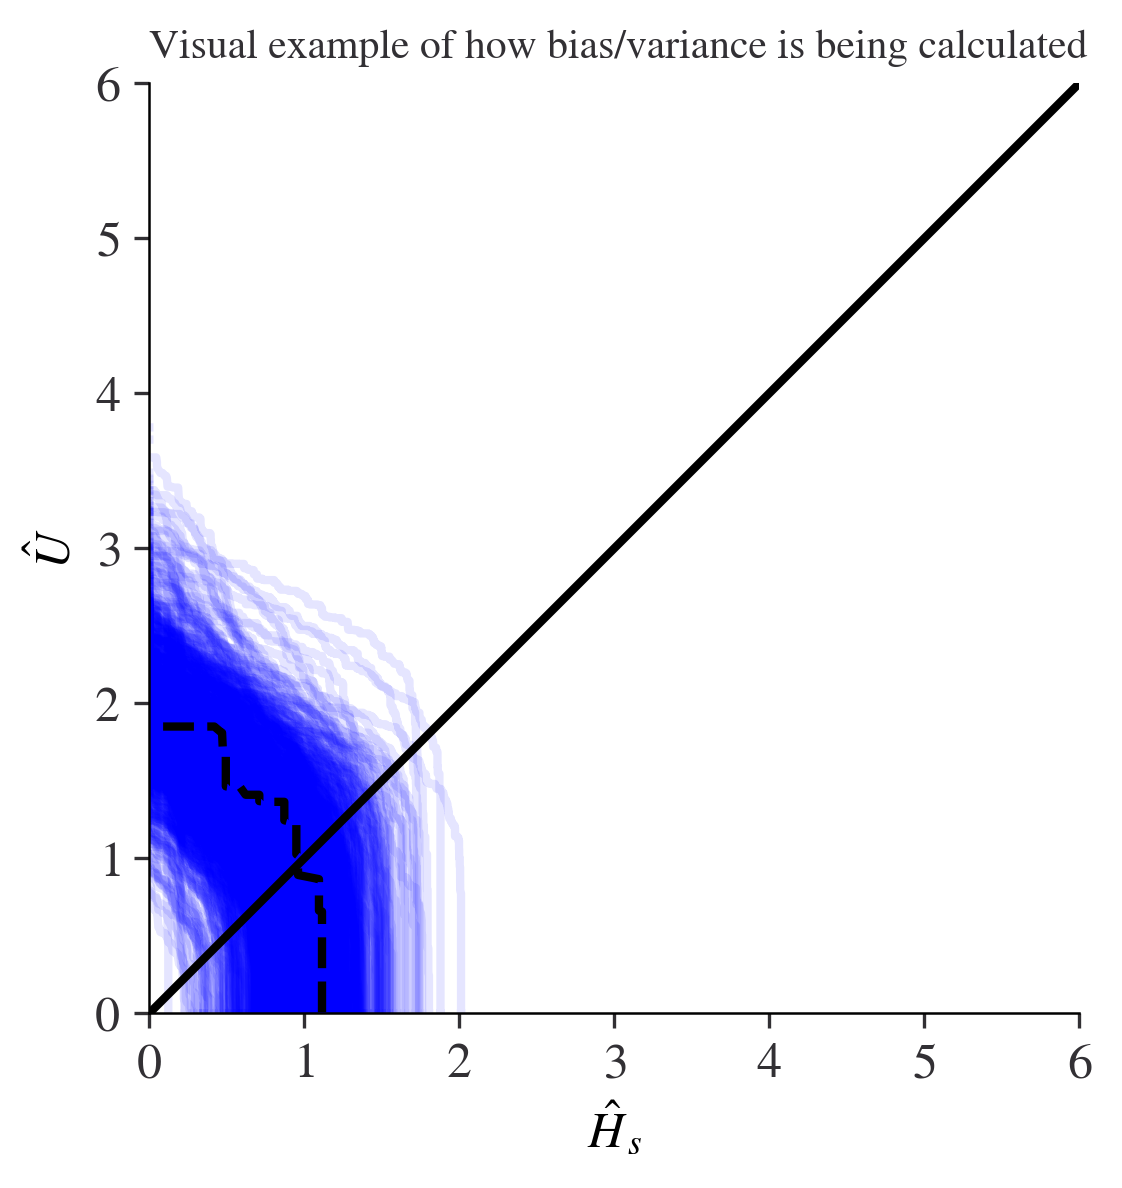

In [68]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(4 , 6),
    facecolor="white",
)
ax.set_xlim(0,6)
ax.set_ylim(0,6)
ax.set_aspect('equal')
for ct in ic_MSTME:
    ax.plot(ct[0],ct[1],c='blue',alpha=0.1)
ax.plot([-10,10],[-10,10],c='black')
ax.plot(ic_original[0],ic_original[1],c='k',linestyle='--')
ax.set_xlabel(STM.H.name_norm())
ax.set_ylabel(STM.U.name_norm())
# ax.set_title("Visual example of how bias/variance is being calculated",size=10)


# Marginal

In [37]:
for S in STM:
    vi = S.idx()
    xi,mu,sigma=mstme_condition.gp[vi].args
    print(f"{S}:\t:(xi,mu,sigma)=({xi:.4f},{mu:.4f},{sigma:.4f})")
    print(f"\t\tLimit:{mu-sigma/xi}")


STM.H:	:(xi,mu,sigma)=(-0.2236,9.1084,4.3725)
		Limit:28.66010820928871
STM.U:	:(xi,mu,sigma)=(-0.4214,28.7105,14.6789)
		Limit:63.5469884937131


# Residual

In [57]:
# wrong residual
for S in STM:
    vi = S.idx()
    params_mean = mstme_condition.params_mean[vi]
    print(f"{S}:\ta:{params_mean[0]:.2f},\tb:{params_mean[1]:.2f}")

STM.H:	a:0.18,	b:0.18
STM.U:	a:0.02,	b:0.26


In [58]:
# for S in STM:
#   vi = S.idx()
params_mean_wrong = np.array([
    [0.46,-0.65,1,1],[0.40,-0.44,1,1]
    ])
residual_wrong = mc._calculate_residual(
  mstme_condition.stm_g,
  params_mean_wrong,
  mstme_condition.thr_com,
)

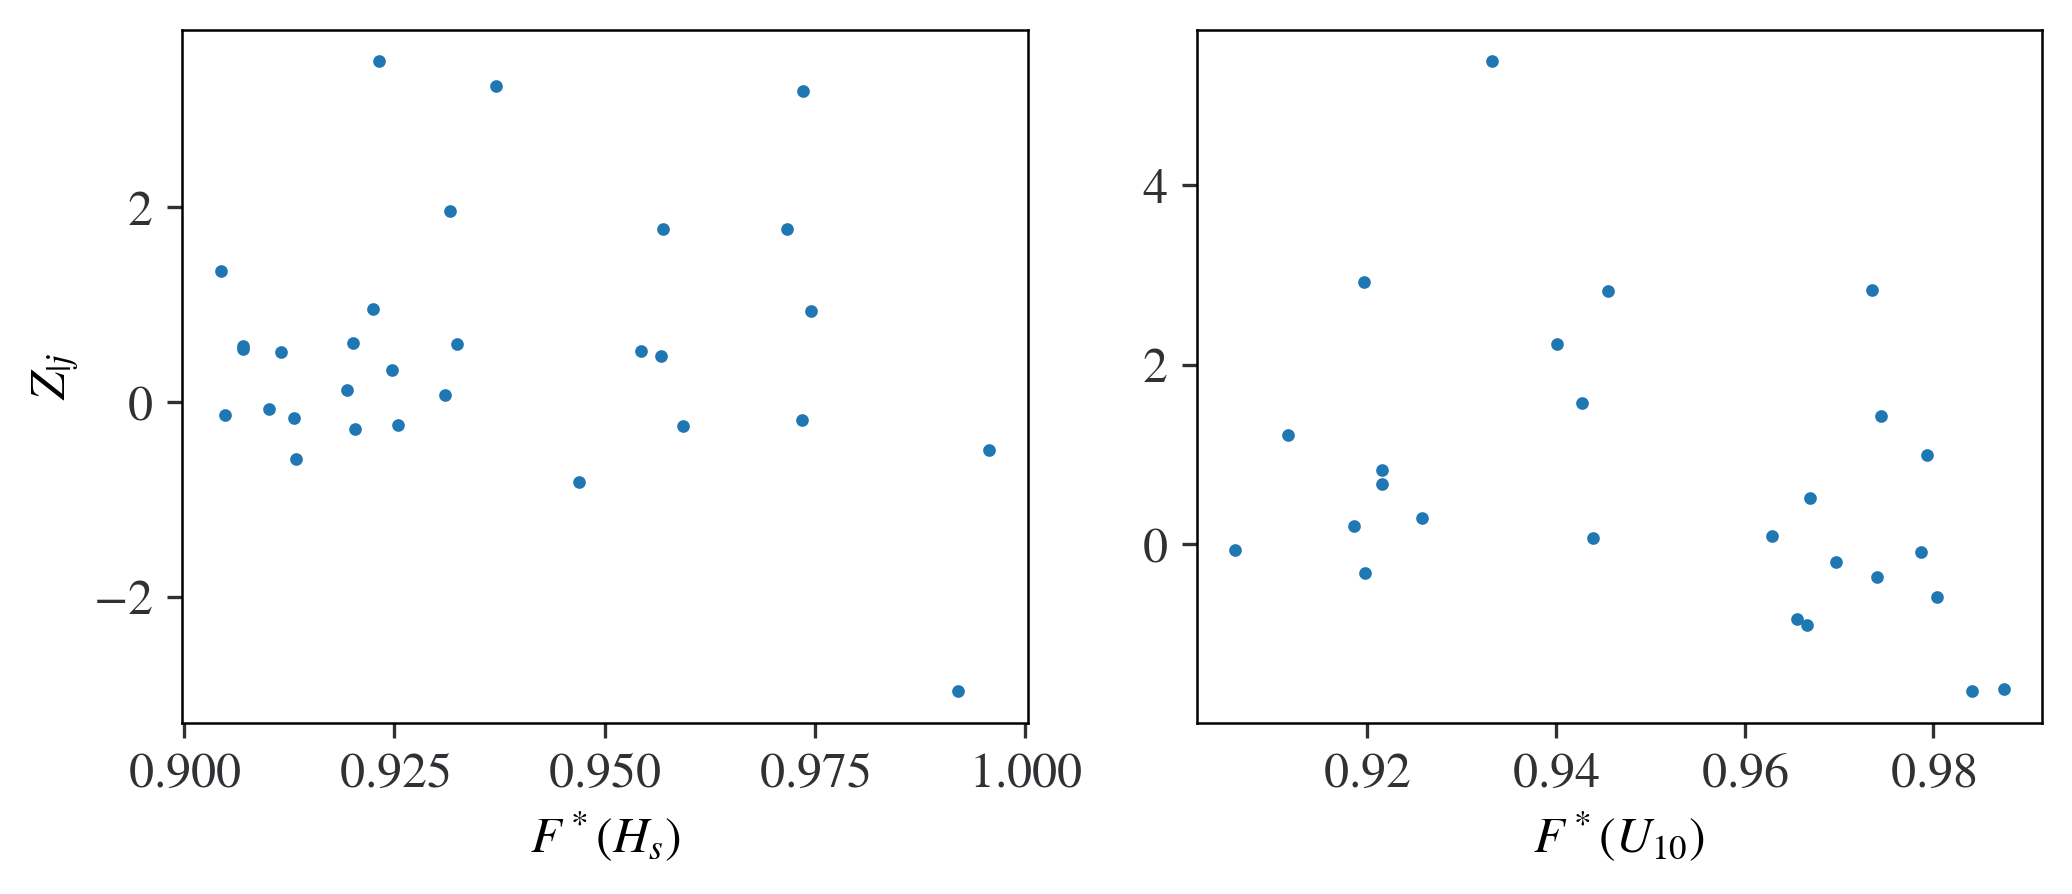

In [59]:
fig, ax = plt.subplots(
  1,
  mstme_condition.num_vars,
  figsize=(4 * mstme_condition.num_vars, 3),
  facecolor="white",
)

# fig.tight_layout()
for S in STM:
  vi = S.idx()
  var_name = S.name()
  ax[vi].scatter(
    mstme_condition.ndist.cdf(mstme_condition.stm_g[vi, mstme_condition.is_e[vi]]),
    residual_wrong[vi],
    s=5,
  )
  ax[vi].set_xlabel(f"$F^*$({var_name}$)$")
ax[0].set_ylabel("$Z_{|j}$")
plt.savefig(dir_out/f"residual_wrong.pdf",bbox_inches='tight')
plt.savefig(dir_out/f"residual_wrong.png",bbox_inches='tight')

# Dump

In [ ]:
# with open(path_notebook,'wb') as f:
#     dill.dump_session(f)